In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'


from dependence_metrics import pseudo_obs,utdc_cfg,utdc_at_threshold


/tmp/ipykernel_5194/3500001011.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def pot(da,threshold,dim):
    
    assert (threshold>=0) & (threshold<1)
    
    return da.where(da>da.quantile(threshold,dim=dim))

def declustered_peaks(da,threshold,window_len,dim):
    #computes peaks above threshold of xr.DataArray and declusters them with a rolling window.
    
    peaks = pot(da,threshold,dim)
    
    return peaks.where(peaks==peaks.rolling({dim:window_len},center=True,min_periods=1).max(skipna=True))

def rolling_max(da,window_len,dim):
    return da.rolling({dim:window_len},center=True,min_periods=1).max()


Load output:

In [3]:
model = 'MPI-ESM1-2-HR'
ssp = 'ssp585'

pr = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/pr_timeseries/',model,
                                  fnmatch.filter(os.listdir(os.path.join('/home/jovyan/CMIP6cf/output/pr_timeseries/',model)),'*'+ssp+'*')[0]))
surge = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/surge_timeseries/',model,
                                  fnmatch.filter(os.listdir(os.path.join('/home/jovyan/CMIP6cf/output/surge_timeseries/',model)),'*'+ssp+'*')[0]))

surge_pr = xr.merge((surge,pr))

dependence = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/surge_pr_dependence/40yr_p97/',model,
                                  fnmatch.filter(os.listdir(os.path.join('/home/jovyan/CMIP6cf/output/surge_pr_dependence/40yr_p97/',model)),'*'+ssp+'*')[0]))

In [4]:
psl_hist = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/psl_europe/',model,'MPI-ESM1-2-HR_gn_historical_day_r2i1p1f1.nc'))
psl_ssp585 = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/psl_europe/',model,'MPI-ESM1-2-HR_gn_ssp585_day_r2i1p1f1.nc'))
psl = xr.concat((psl_hist,psl_ssp585),dim='time')

sfcWind_hist = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/sfcWind_europe/',model,'MPI-ESM1-2-HR_gn_historical_day_r2i1p1f1.nc'))
sfcWind_ssp585 = xr.open_dataset(os.path.join('/home/jovyan/CMIP6cf/output/sfcWind_europe/',model,'MPI-ESM1-2-HR_gn_ssp585_day_r2i1p1f1.nc'))
sfcWind = xr.concat((sfcWind_hist,sfcWind_ssp585),dim='time')


In [5]:
output_yrs = np.arange(1880,2100,20)
window_len=40 #may need to increase? indicate settings in output folder?

#construct time window indices
if len(np.unique(surge_pr.time.resample(time='1Y').count()))>1: #remove leap days so that each computation window has the same length
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        surge_pr = surge_pr.sel(time=~((surge_pr.time.dt.month == 2) & (surge_pr.time.dt.day == 29))) #^probably (hopefully) only has a small effect on the results

days_in_year = int(surge_pr.time.resample(time='1Y').count()[0])

if window_len%2 !=0: #odd
    window_start_idx = days_in_year*(output_yrs-1850-int(np.floor(window_len/2)))
    first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)
else: #even
    window_start_idx = days_in_year*(output_yrs-1850-int(window_len/2)+1)
    first_window_idx = np.arange(0*days_in_year,window_len*days_in_year)

if np.max(first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:])>=len(surge_pr.time):
    raise Exception('Windows exceed simulation length.')

window_idx = xr.DataArray( #indices of windows
    data=first_window_idx[:,np.newaxis]+window_start_idx[np.newaxis,:],
    dims=["time_in_window_idx","window"],
    coords=dict(
        time_in_window_idx=first_window_idx,
        window=output_yrs
    ),
)
surge_pr_wdws = surge_pr.isel(time=window_idx).isel(member_id=1)
psl_wdws = psl.isel(time=window_idx).isel(member_id=0)
sfcWind_wdws = sfcWind.isel(time=window_idx).isel(member_id=0)

In [6]:
surge_pr_wdws.load()
psl_wdws.load()
sfcWind_wdws.load()

<xarray.Dataset>
Dimensions:             (lat: 36, lon: 46, time_in_window_idx: 14600, window: 11)
Coordinates:
  * lat                 (lat) float64 35.06 36.0 36.93 ... 67.79 68.73 69.66
  * lon                 (lon) float64 -30.0 -29.06 -28.12 ... 13.12 14.06 15.0
    time                (time_in_window_idx, window) datetime64[ns] 1860-12-2...
    member_id           <U8 'r2i1p1f1'
    height              float64 10.0
  * time_in_window_idx  (time_in_window_idx) int64 0 1 2 3 ... 14597 14598 14599
  * window              (window) int64 1880 1900 1920 1940 ... 2040 2060 2080
Data variables:
    sfcWind             (time_in_window_idx, window, lat, lon) float32 7.115 ...
Attributes: (12/64)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            18261.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:zstore:          gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-...
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.r2i...
    original_key:                     MPI-ESM1-2-HR.gn.historical.day.r2i1p1f1

In [7]:
pr_peaks = pot(surge_pr_wdws['pr'],.99,dim='time_in_window_idx')
surge_peaks = pot(surge_pr_wdws['surge'],.99,dim='time_in_window_idx')
pr_peaks_declustered = declustered_peaks(surge_pr_wdws['pr'],.99,3,dim='time_in_window_idx')
surge_peaks_declustered = declustered_peaks(surge_pr_wdws['surge'],.99,3,dim='time_in_window_idx')

In [8]:
co_occurring = np.isfinite((rolling_max(pr_peaks_declustered,2*2+1,dim='time_in_window_idx')*surge_peaks_declustered))
num_co_occurring = np.isfinite((rolling_max(pr_peaks_declustered,2*2+1,dim='time_in_window_idx')*surge_peaks_declustered)).sum(dim='time_in_window_idx')

In [9]:
num_co_occurring_wo_decl = np.isfinite((rolling_max(pr_peaks,2*2+1,dim='time_in_window_idx')*surge_peaks)).sum(dim='time_in_window_idx')

In [10]:
mean_surge_co_occurring = surge_peaks_declustered.where(co_occurring.sel(tg='kinlochbervi_p918_uk.csv')).mean(dim='time_in_window_idx')
#mean_surge_no_co = surge_peaks_declustered.where(~np.isfinite(rolling_max(pr_peaks_declustered,2*2+1,dim='time_in_window_idx'))).mean(dim='time_in_window_idx')

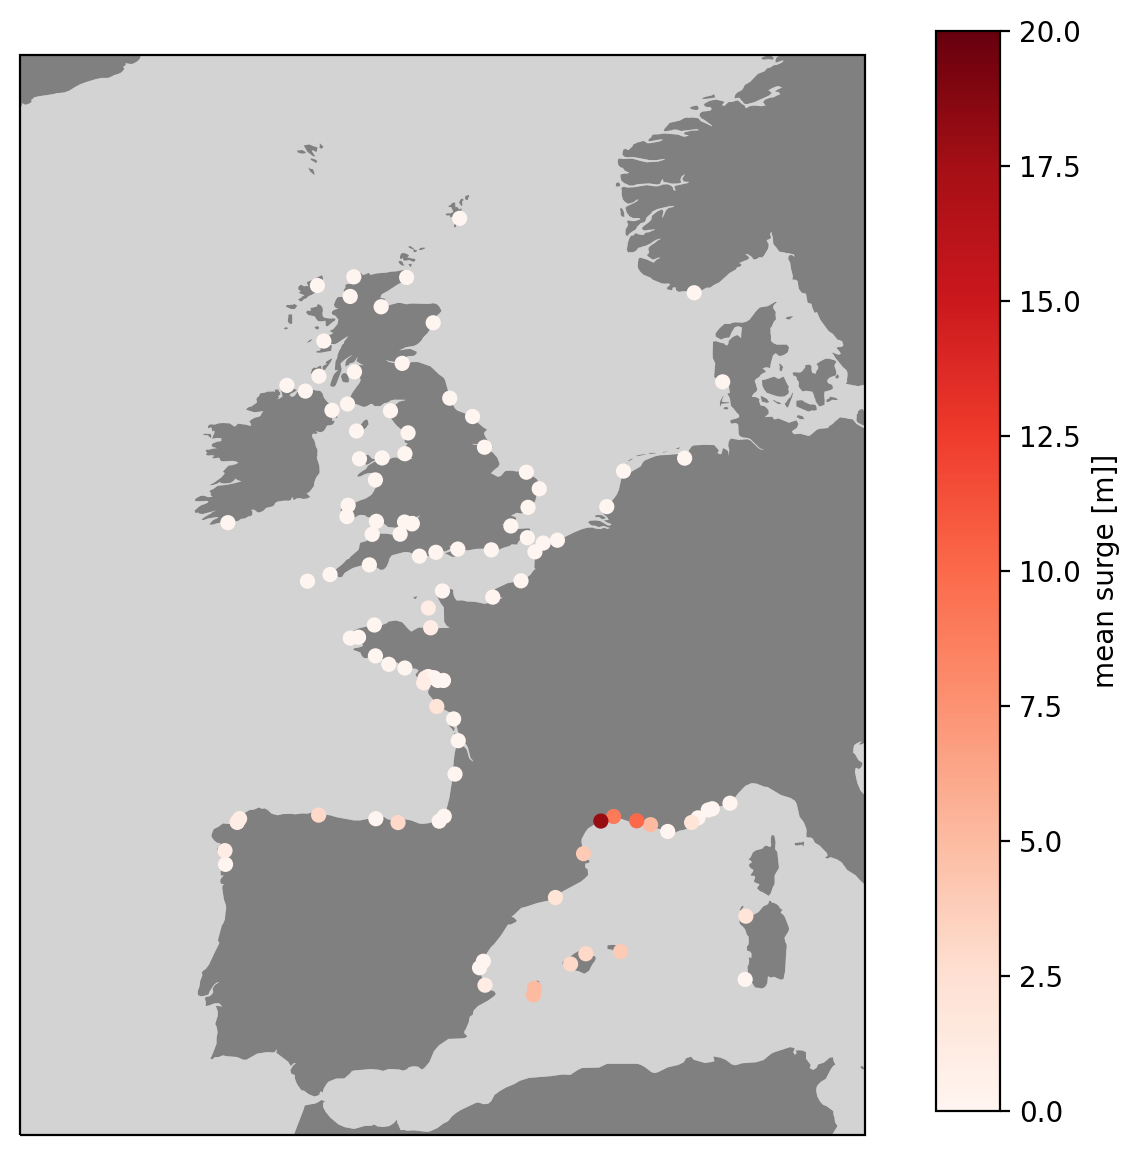

In [11]:
fig=plt.figure(figsize=(12,8)) #generate figure  
gs = fig.add_gridspec(1,2)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=co_occurring.where(co_occurring.sel(tg='sete_france.csv')).sum(dim='time_in_window_idx').isel(window=-1),cmap='Reds',vmin=0,vmax=20,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean surge [m]]')


plot mean patterns during extreme events at certain tide gauge:

ValueError: 'c' argument has 1199 elements, which is inconsistent with 'x' and 'y' with size 109.

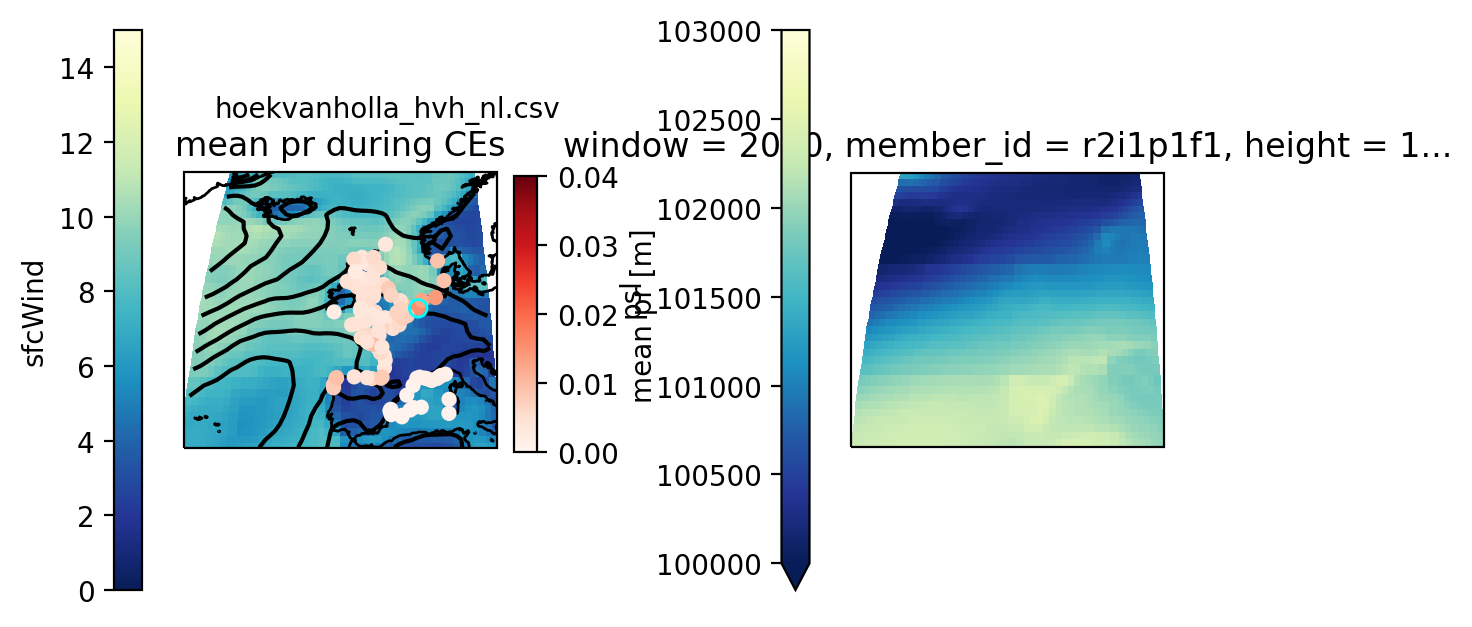

In [37]:

tg = 'arcachon_eyrac_.csv'

tg='heysham_p050_uk.csv'






tg = 'kinlochbervi_p918_uk.csv'

tg='whitby_p174_uk.csv'
tg='sete_france.csv'
tg='hoekvanholla_hvh_nl.csv'
fig=plt.figure(figsize=(7,8)) #generate figure  
gs = fig.add_gridspec(2,2)
gs.update(wspace=.6)

#pr during CE
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

#ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='lightgrey')
#ax.add_feature(cartopy.feature.LAND, zorder=1, facecolor='grey')
sfcWind_wdws.sfcWind.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='YlGnBu_r',vmin=0,vmax=15,cbar_kwargs={'location':'left'})
psl_wdws.psl.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000).plot.contour(levels=10,colors=['black'],ax=ax,transform=ccrs.PlateCarree())

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.pr.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000),cmap='Reds',vmin=0,vmax=.04,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)
ax.coastlines()
ax.set_extent([-30, 15, 35, 70], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean pr [m]')
ax.set_title('mean pr during CEs')
ax.annotate(tg,xy=(.1,1.2),xycoords='axes fraction')


#pr during surge peak not CE
ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

#ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
#ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')
condition = (np.isfinite(surge_peaks_declustered.sel(tg=tg)))
little_pr = np.where(surge_pr_wdws.pr.sel(tg=tg).sel(window=2000)<surge_pr_wdws.pr.sel(tg=tg).sel(window=2000).quantile(.8,dim='time_in_window_idx'))[0]

psl_wdws.psl.isel(time_in_window_idx=little_pr).where(condition).mean(dim='time_in_window_idx').sel(window=2000).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='YlGnBu_r',vmin=1*1e5,vmax=1.03*1e5,cbar_kwargs={'location':'left'})
#psl_wdws.psl.where((np.isfinite(surge_peaks_declustered.sel(tg=tg))) & (~co_occurring.sel(tg=tg))).mean(dim='time_in_window_idx').sel(window=2000).plot.contour(levels=np.arange(96000,104000,200),colors=['black'],ax=ax,transform=ccrs.PlateCarree())
sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.pr.isel(time_in_window_idx=little_pr).where(condition).mean(dim='time_in_window_idx').sel(window=2000),cmap='Reds',vmin=0,vmax=.04,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)
ax.coastlines()
ax.set_extent([-30, 15, 35, 70], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean pr [m]')
ax.set_title('mean pr during surge peak not CE')


#surge during CE
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

sfcWind_wdws.sfcWind.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='YlGnBu_r',vmin=0,vmax=15,cbar_kwargs={'location':'left'})
psl_wdws.psl.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000).plot.contour(levels=10,colors=['black'],ax=ax,transform=ccrs.PlateCarree())

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.surge.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000),cmap='Reds',vmin=0,vmax=1,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)
ax.coastlines()
ax.set_extent([-30, 15, 35, 70], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean surge [m]')
ax.set_title('mean surge during CEs')
'''
#surge during pr peak not CE
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

#ax.add_feature(cartopy.feature.OCEAN, zorder=1,facecolor='lightgrey')
#ax.add_feature(cartopy.feature.LAND, zorder=1, facecolor='grey')

psl_wdws.psl.where((np.isfinite(pr_peaks_declustered.sel(tg=tg)))).mean(dim='time_in_window_idx').sel(window=2000).plot(ax=ax,transform=ccrs.PlateCarree(),cmap='YlGnBu_r',vmin=1*1e5,vmax=1.03*1e5,cbar_kwargs={'location':'left'})
psl_wdws.psl.where((np.isfinite(pr_peaks_declustered.sel(tg=tg)))).mean(dim='time_in_window_idx').sel(window=2000).plot.contour(levels=np.arange(96000,104000,200),colors=['black'],ax=ax,transform=ccrs.PlateCarree())


sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.surge.where((np.isfinite(pr_peaks_declustered.sel(tg=tg))) & (~co_occurring.sel(tg=tg))).mean(dim='time_in_window_idx').sel(window=2000),cmap='Reds',vmin=0,vmax=1,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)
ax.coastlines()
ax.set_extent([-30, 15, 35, 70], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean surge [m]')
ax.set_title('mean surge during pr peak not CE')
'''

<xarray.DataArray 'psl' (lat: 36, lon: 46)>
array([[102263.9  , 102281.35 , 102297.234, ..., 102039.37 , 102003.71 ,
        101978.77 ],
       [102253.28 , 102269.13 , 102279.97 , ..., 102006.97 , 101980.32 ,
        101950.984],
       [102222.445, 102239.56 , 102256.21 , ..., 101969.03 , 101954.414,
        101919.01 ],
       ...,
       [100643.28 , 100619.27 , 100602.04 , ..., 100197.23 , 100225.055,
        100268.67 ],
       [100865.74 , 100877.26 , 100879.05 , ..., 100152.984, 100169.695,
        100190.734],
       [101300.01 , 101284.19 , 101244.36 , ..., 100126.72 , 100143.41 ,
        100160.54 ]], dtype=float32)
Coordinates:
  * lat           (lat) float64 35.06 36.0 36.93 37.87 ... 67.79 68.73 69.66
  * lon           (lon) float64 -30.0 -29.06 -28.12 -27.19 ... 13.12 14.06 15.0
    window        int64 2000
    member_id     <U8 'r2i1p1f1'
    height        float64 10.0
    tg            <U23 'hoekvanholla_hvh_nl.csv'
    gridcell_lat  float64 51.9
    gridcell_lon  float64 3.75
    quantile      float64 0.99

In [31]:
np.where(surge_pr_wdws.pr.sel(tg=tg).sel(window=2000)<surge_pr_wdws.pr.sel(tg=tg).sel(window=2000).quantile(.8,dim='time_in_window_idx'))


(array([    1,     2,     3, ..., 14593, 14596, 14598]),)

In [27]:
psl_wdws.psl.sel(window=2000).isel(time_in_window_idx=np.where(co_occurring.sel(tg=tg).sel(window=2000))[0][0])


<xarray.DataArray 'psl' (lat: 36, lon: 46)>
array([[102302.375, 102228.375, 102141.375, ..., 102528.625, 102475.625,
        102423.875],
       [102369.875, 102312.875, 102232.875, ..., 102540.875, 102493.125,
        102447.125],
       [102395.125, 102349.875, 102292.875, ..., 102547.625, 102538.625,
        102504.375],
       ...,
       [ 98813.625,  98798.375,  98797.375, ...,  98488.375,  98487.375,
         98483.125],
       [ 99099.375,  99115.625,  99119.375, ...,  98282.875,  98271.125,
         98255.875],
       [ 99488.125,  99455.625,  99404.625, ...,  98080.125,  98068.125,
         98055.875]], dtype=float32)
Coordinates:
  * lat                 (lat) float64 35.06 36.0 36.93 ... 67.79 68.73 69.66
  * lon                 (lon) float64 -30.0 -29.06 -28.12 ... 13.12 14.06 15.0
    time                datetime64[ns] 1981-12-02T12:00:00
    member_id           <U8 'r2i1p1f1'
    time_in_window_idx  int64 367
    window              int64 2000
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Sea Level Pressure
    history:        2019-08-29T21:59:06Z altered by CMOR: replaced missing va...
    long_name:      Sea Level Pressure
    standard_name:  air_pressure_at_mean_sea_level
    units:          Pa

(array([  367,   654,   691,   735,  1080,  1100,  1720,  1748,  2118,
         2452,  3178,  3219,  3222,  3353,  3585,  3962,  3983,  3985,
         4051,  4307,  4310,  4368,  6165,  6622,  6628,  6864,  6883,
         6899,  6935,  7602,  7647,  8016,  8385,  8720,  9017,  9432,
         9435,  9801,  9841,  9845,  9868,  9870, 10546, 10578, 10586,
        10949, 10969, 10975, 11253, 11272, 11282, 11646, 11650, 12012,
        12082, 12398, 12721, 12723, 13061, 13410, 13471, 13524, 13885,
        14144, 14156]),)

In [14]:
np.arange(99000,103000,500)

array([ 99000, 100000, 101000, 102000])

<xarray.Dataset>
Dimensions:       (window: 11, lat: 34, lon: 28)
Coordinates:
  * lat           (lat) float64 35.06 36.0 36.0 36.93 ... 63.12 64.05 64.99
  * lon           (lon) float64 -15.0 -14.06 -13.12 -12.19 ... 10.31 11.25 12.19
    member_id     <U8 'r2i1p1f1'
  * window        (window) int64 1880 1900 1920 1940 ... 2020 2040 2060 2080
    height        float64 10.0
    tg            <U18 'whitby_p174_uk.csv'
    gridcell_lat  float64 54.7
    gridcell_lon  float64 359.1
    quantile      float64 0.98
Data variables:
    psl           (window, lat, lon) float32 1.021e+05 1.021e+05 ... 1.011e+05

Text(0.5, 1.0, 'mean surge during pr peak not CE')

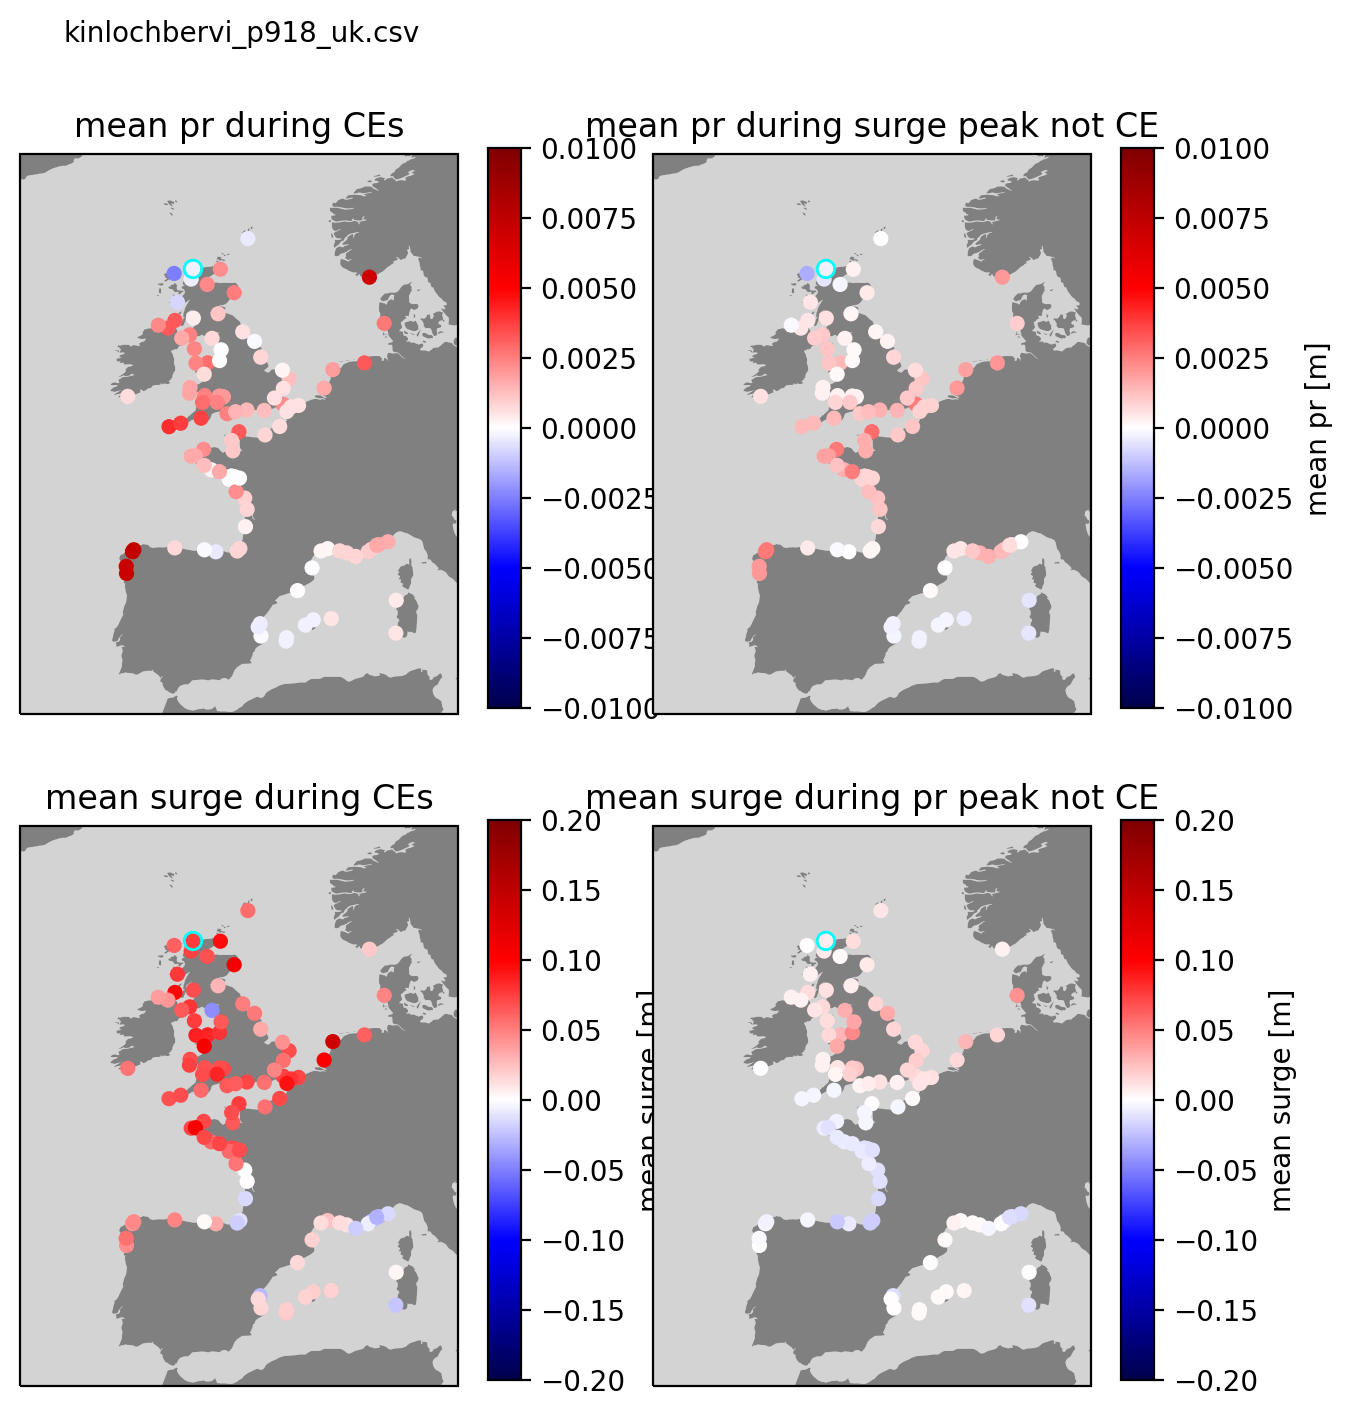

In [65]:

tg = 'arcachon_eyrac_.csv'
tg='delfzijl_del_nl.csv'
tg='heysham_p050_uk.csv'
tg='whitby_p174_uk.csv'
tg='devonport_p002_uk.csv'
tg = 'kinlochbervi_p918_uk.csv'

fig=plt.figure(figsize=(7,8)) #generate figure  
gs = fig.add_gridspec(2,2)
gs.update(wspace=.4)

#pr during CE
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.pr.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2080)-surge_pr_wdws.pr.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000),cmap='seismic',vmin=-.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean pr [m]')
ax.set_title('mean pr during CEs')
ax.annotate(tg,xy=(.1,1.2),xycoords='axes fraction')

#pr during surge peak not CE
ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.pr.where((np.isfinite(surge_peaks_declustered.sel(tg=tg))) & (~co_occurring.sel(tg=tg))).mean(dim='time_in_window_idx').sel(window=2080)-surge_pr_wdws.pr.where((np.isfinite(surge_peaks_declustered.sel(tg=tg))) & (~co_occurring.sel(tg=tg))).mean(dim='time_in_window_idx').sel(window=2000),cmap='seismic',vmin=-0.01,vmax=.01,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean pr [m]')
ax.set_title('mean pr during surge peak not CE')


#surge during CE
ax = plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.surge.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2080)-surge_pr_wdws.surge.where(co_occurring.sel(tg=tg)).mean(dim='time_in_window_idx').sel(window=2000),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean surge [m]')
ax.set_title('mean surge during CEs')

#surge during pr peak not CE
ax = plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=surge_pr_wdws.surge.where((np.isfinite(pr_peaks_declustered.sel(tg='kinlochbervi_p918_uk.csv'))) & (~co_occurring.sel(tg='kinlochbervi_p918_uk.csv'))).mean(dim='time_in_window_idx').sel(window=2080)-surge_pr_wdws.surge.where((np.isfinite(pr_peaks_declustered.sel(tg='kinlochbervi_p918_uk.csv'))) & (~co_occurring.sel(tg='kinlochbervi_p918_uk.csv'))).mean(dim='time_in_window_idx').sel(window=2000),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.scatter(surge_pr_wdws.sel(tg=tg).lon,surge_pr_wdws.sel(tg=tg).lat,edgecolor='cyan',s=40,transform=ccrs.PlateCarree(),facecolor='None',zorder=5)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='mean surge [m]')
ax.set_title('mean surge during pr peak not CE')


In [14]:
surge_pr_wdws.tg.values

array(['arcachon_eyrac_.csv', 'montoir_de_bretagne_.csv',
       'barcelona_barcelona_spain.csv', 'paimboeuf_.csv',
       'saint_malo_.csv', 'portbury_p341_uk.csv', 'dover_p012_uk.csv',
       'portpatrick_p063_uk.csv', 'alcudia_alcudia_spain.csv',
       'formentera_formentera_spain.csv', 'donges_.csv',
       'aberdeen_p038_uk.csv', 'avonmouth_p060_uk.csv',
       'esbjerg_130121_denmark.csv', 'la_rochelle_la_palli_.csv',
       'monaco_port_hercule_france.csv', 'newhaven_p011_uk.csv',
       'le_havre_.csv', 'llandudno_p007_uk.csv', 'bangor_p662_uk.csv',
       'roscoff_.csv', 'port_vendres_france.csv', 'holyhead_p054_uk.csv',
       'portellen_p202_uk.csv', 'tregde_006_norway.csv',
       'le_conquet_.csv', 'saint_nazaire_.csv',
       'port_camargue_france.csv', 'morayfirth_p207_uk.csv',
       'marseille_france.csv', 'ullapool_p043_uk.csv', 'cordemais_.csv',
       'port_tudy_.csv', 'sagunto_sagunto_spain.csv',
       'bilbao_bilbao_spain.csv', 'northshields_p032_uk.csv',
      

Text(2, 0.5, 'd(# joint extremes/decade)\nssp585')

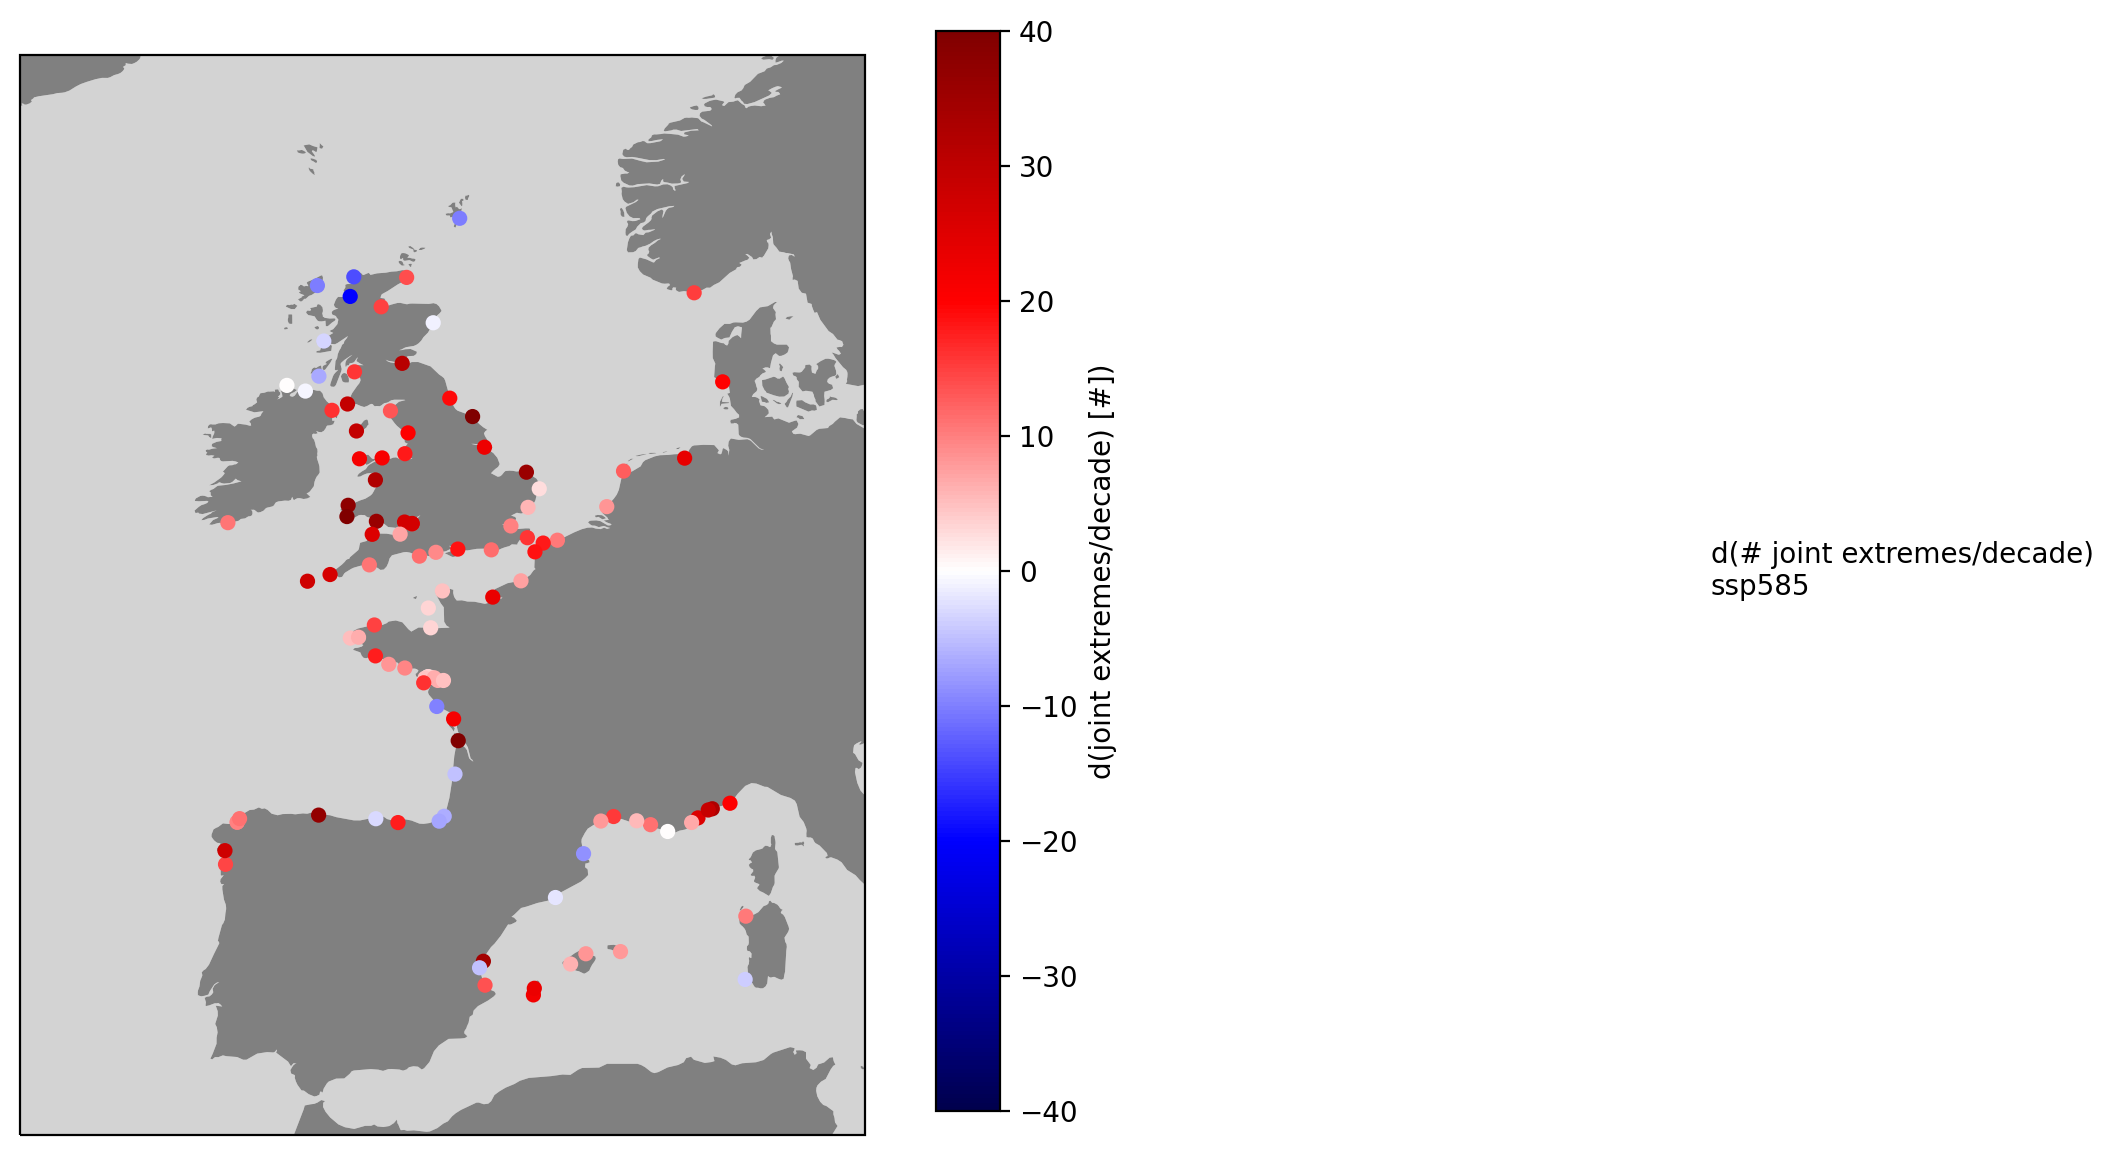

In [10]:
fig=plt.figure(figsize=(12,8)) #generate figure  
gs = fig.add_gridspec(1,2)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=100*(num_co_occurring.sel(window=2080)-num_co_occurring.sel(window=2000))/num_co_occurring.sel(window=2000),cmap='seismic',vmin=-40,vmax=40,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='d(joint extremes/decade) [#])')
ax.annotate('d(# joint extremes/decade)\n'+ssp,(2,.5),xycoords='axes fraction')


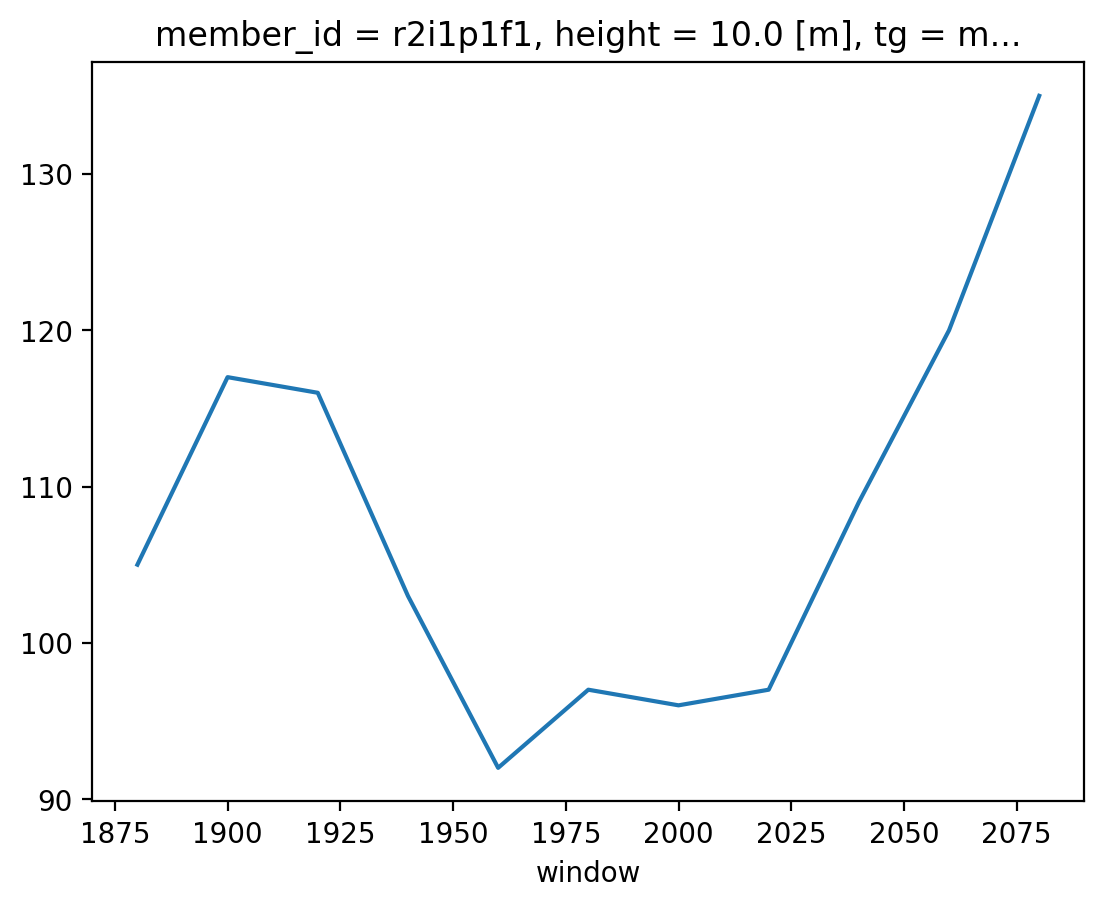

In [15]:
num_co_occurring.sel(tg='milfordhaven_p056_uk.csv').plot()

Text(2, 0.5, 'd(# joint extremes/decade)\nssp585')

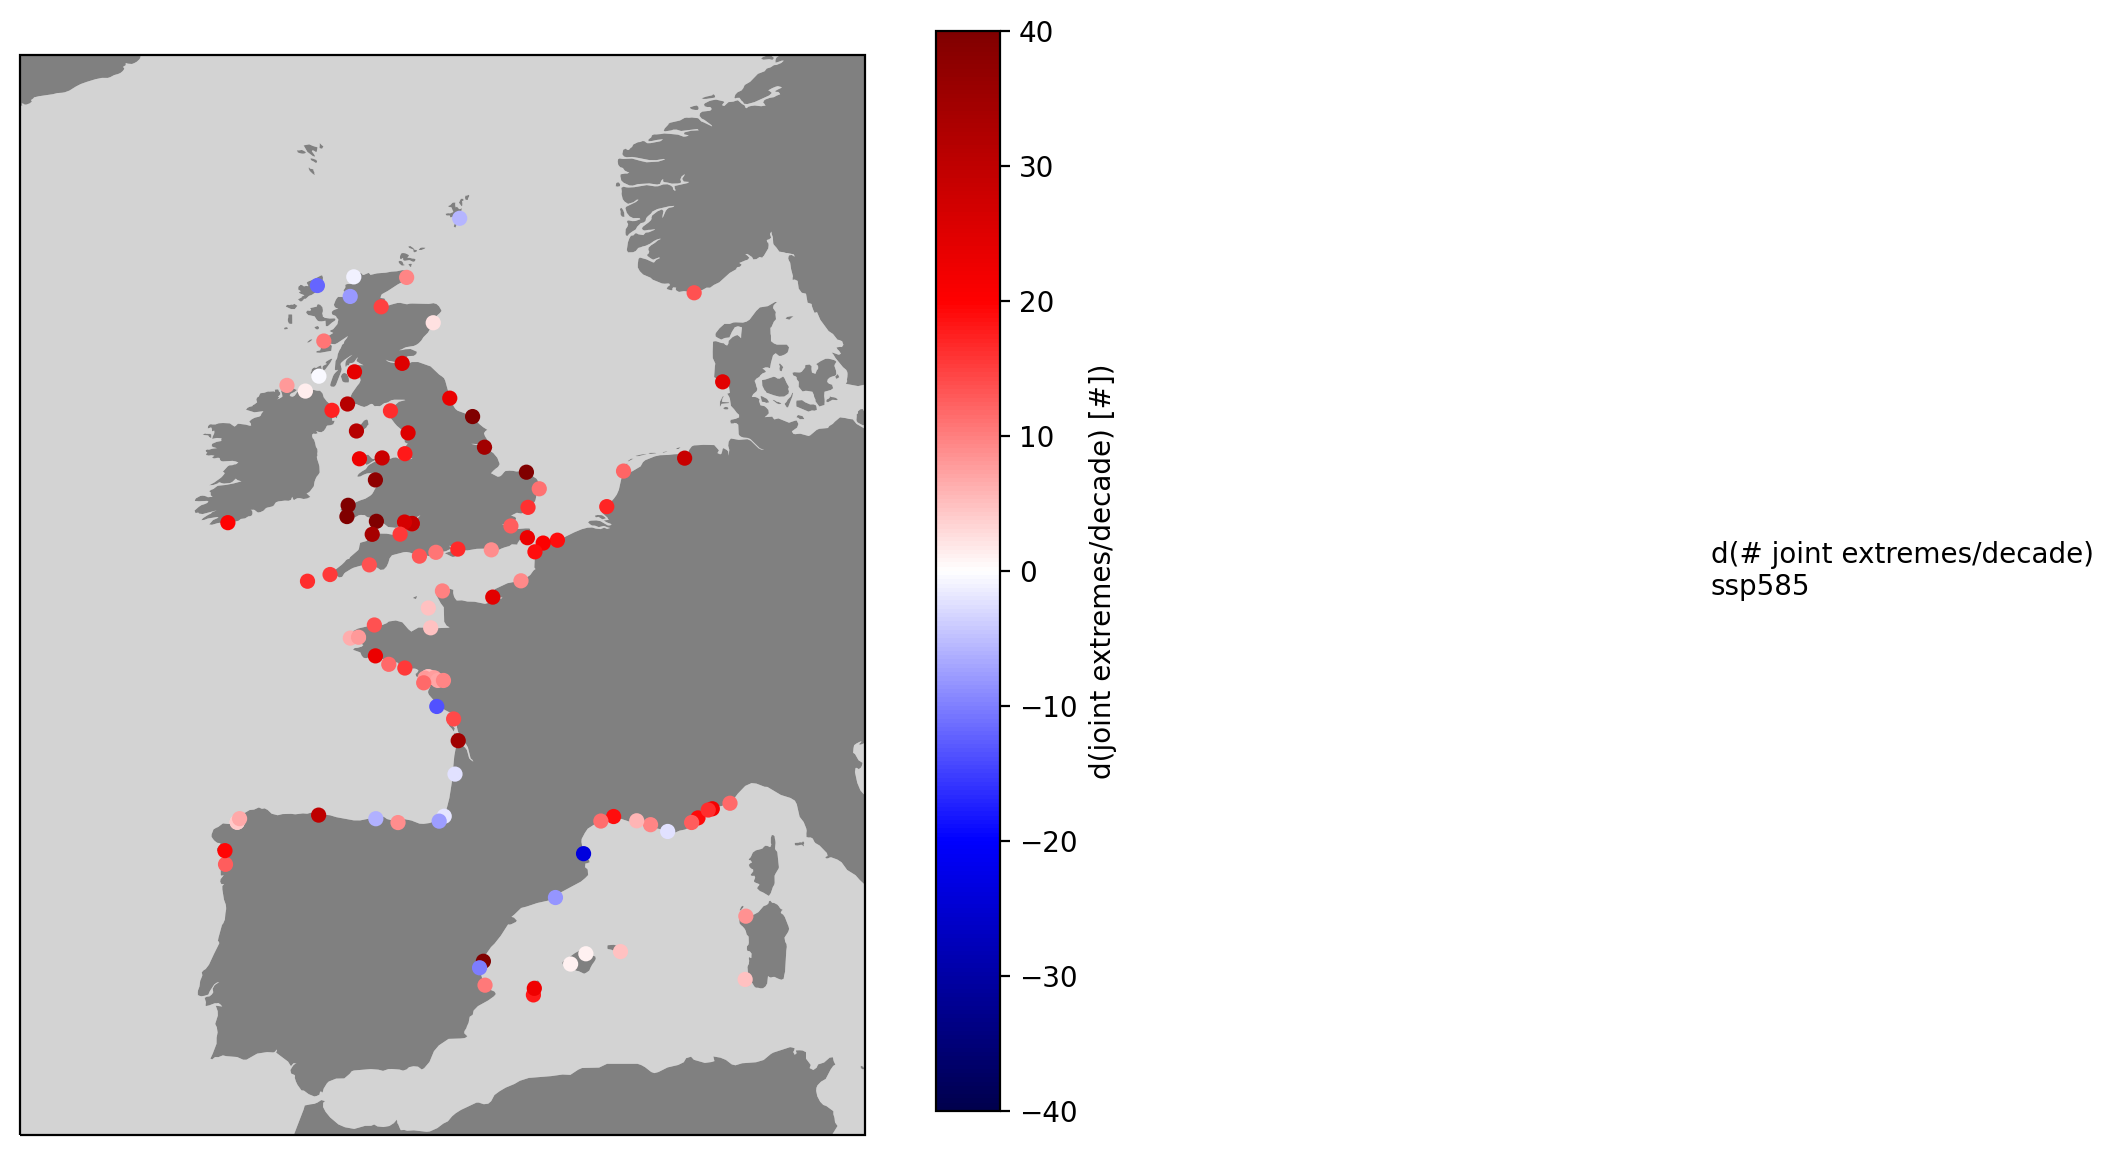

In [11]:
fig=plt.figure(figsize=(12,8)) #generate figure  
gs = fig.add_gridspec(1,2)


#1991-2020
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(surge_pr_wdws.lon,surge_pr_wdws.lat,c=100*(num_co_occurring_wo_decl.sel(window=2080)-num_co_occurring_wo_decl.sel(window=2000))/num_co_occurring_wo_decl.sel(window=2000),cmap='seismic',vmin=-40,vmax=40,s=20,transform=ccrs.PlateCarree(),zorder=3)

ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='d(joint extremes/decade) [#])')
ax.annotate('d(# joint extremes/decade)\n'+ssp,(2,.5),xycoords='axes fraction')


Text(0.5, 1.0, 'difference')

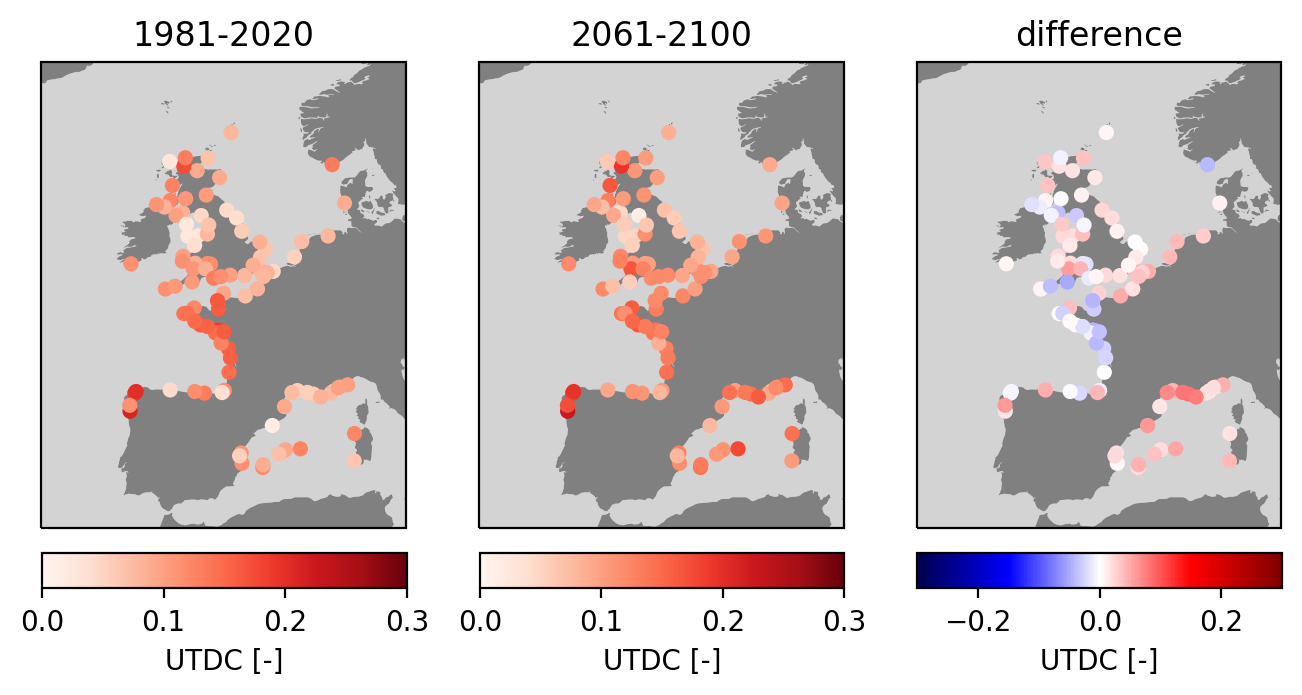

In [11]:
#plot delta UTDC
fig=plt.figure(figsize=(8,8)) #generate figure  
gs = fig.add_gridspec(1,3)

#pd
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(dependence.lon,dependence.lat,c=dependence.ktau.sel(statistic='coef',extreme_variate='surge').sel(window=2000).mean(dim='member_id'),cmap='Reds',vmin=0,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
ax.set_title('1981-2020')

#fut
ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(dependence.lon,dependence.lat,c=dependence.ktau.sel(statistic='coef',extreme_variate='surge').sel(window=2080).mean(dim='member_id'),cmap='Reds',vmin=0,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
ax.set_title('2061-2100')

#delta
ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(dependence.lon,dependence.lat,c=dependence.ktau.sel(statistic='coef',extreme_variate='surge').sel(window=2080).mean(dim='member_id')-dependence.ktau.sel(statistic='coef',extreme_variate='surge').sel(window=2000).mean(dim='member_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
ax.set_title('difference')

Text(0.5, 1.0, 'difference')

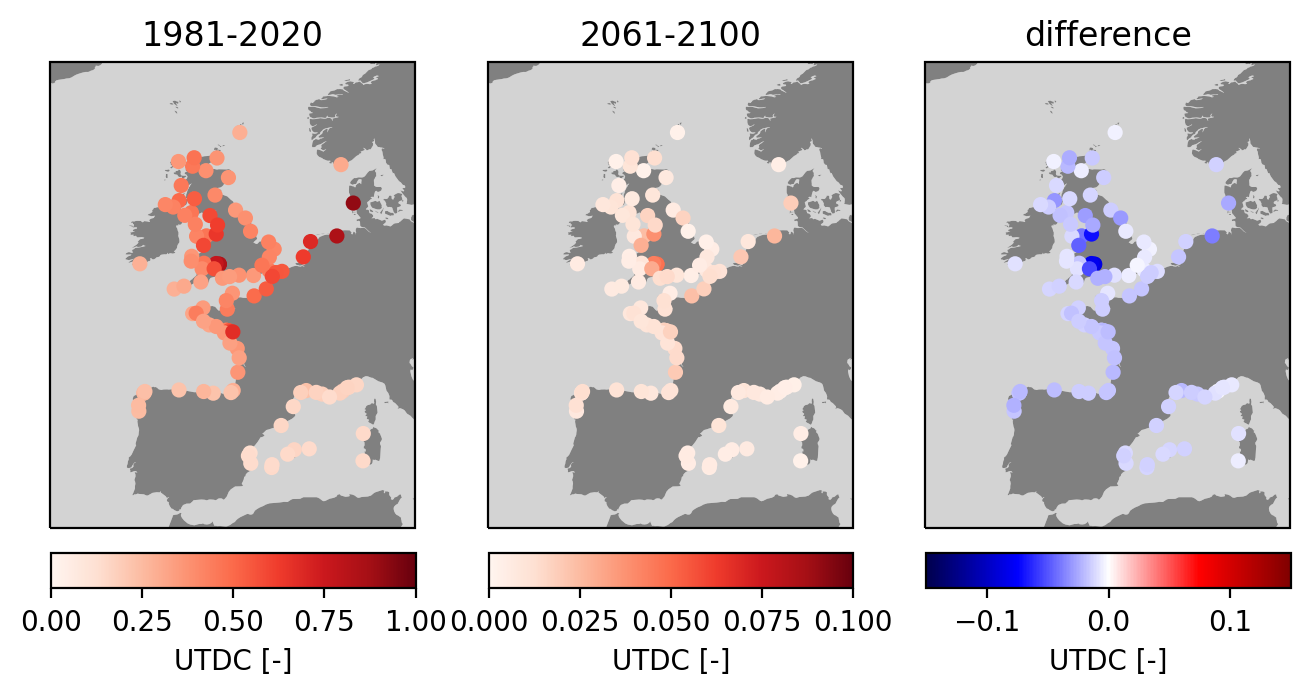

In [45]:
#plot delta UTDC
fig=plt.figure(figsize=(8,8)) #generate figure  
gs = fig.add_gridspec(1,3)

#pd
ax = plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(dependence.lon,dependence.lat,c=dependence.surge_thresholds.isel(quantile=-3).sel(window=2000).mean(dim='member_id'),cmap='Reds',vmin=0,vmax=1,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
ax.set_title('1981-2020')

#fut
ax = plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(dependence.lon,dependence.lat,c=dependence.surge_thresholds.isel(quantile=-3).mean(dim='member_id').std(dim='window'),cmap='Reds',vmin=0,vmax=.1,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
ax.set_title('2061-2100')

#delta
ax = plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=0))

ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

sc=ax.scatter(dependence.lon,dependence.lat,c=dependence.surge_thresholds.isel(quantile=-3).sel(window=2080).mean(dim='member_id')-dependence.surge_thresholds.isel(quantile=-3).sel(window=2000).mean(dim='member_id'),cmap='seismic',vmin=-.15,vmax=.15,s=20,transform=ccrs.PlateCarree(),zorder=3)
ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())

cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(0.04, -.1,1,.075),bbox_transform=ax.transAxes)
cb=fig.colorbar(sc, cax=cax,orientation='horizontal',label='UTDC [-]')
ax.set_title('difference')

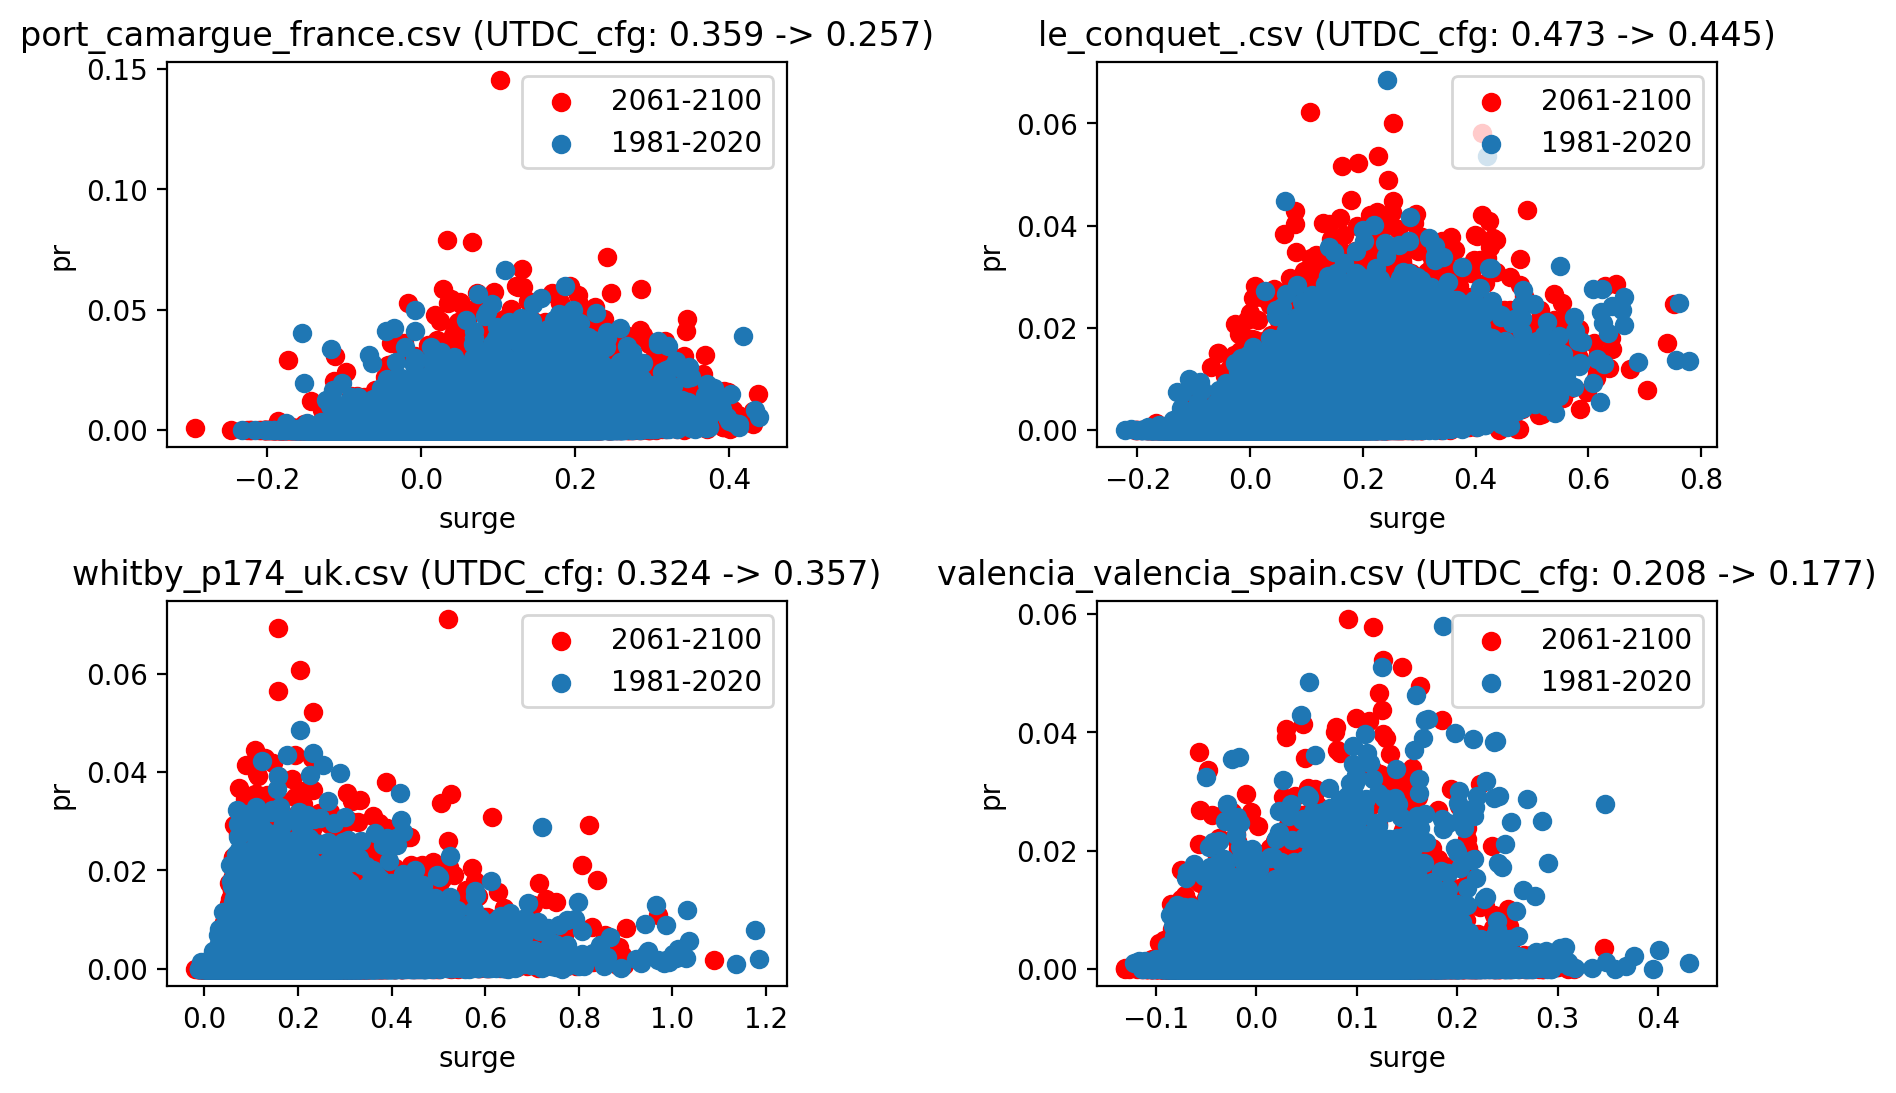

In [12]:
plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2,2)
gs.update(wspace=.5,hspace=.4)
tgs = ['port_camargue_france.csv','le_conquet_.csv','whitby_p174_uk.csv','valencia_valencia_spain.csv']

for t,tg in enumerate(tgs):
    
    ax = plt.subplot(gs[np.unravel_index(t,(2,2))])
    data = surge_pr_windows.sel(window=2080,tg=tg)
    ax.scatter(data.surge,data.pr,color='red',label='2061-2100')
    data = surge_pr_windows.sel(window=2000,tg=tg)
    ax.scatter(data.surge,data.pr,label='1981-2020')
    ax.set_title(tg+' (UTDC_cfg: '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2000).mean(dim='member_id').values)[0:5]+' -> '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2080).mean(dim='member_id').values)[0:5]+')')
    ax.legend()
    ax.set_xlabel('surge')
    ax.set_ylabel('pr')


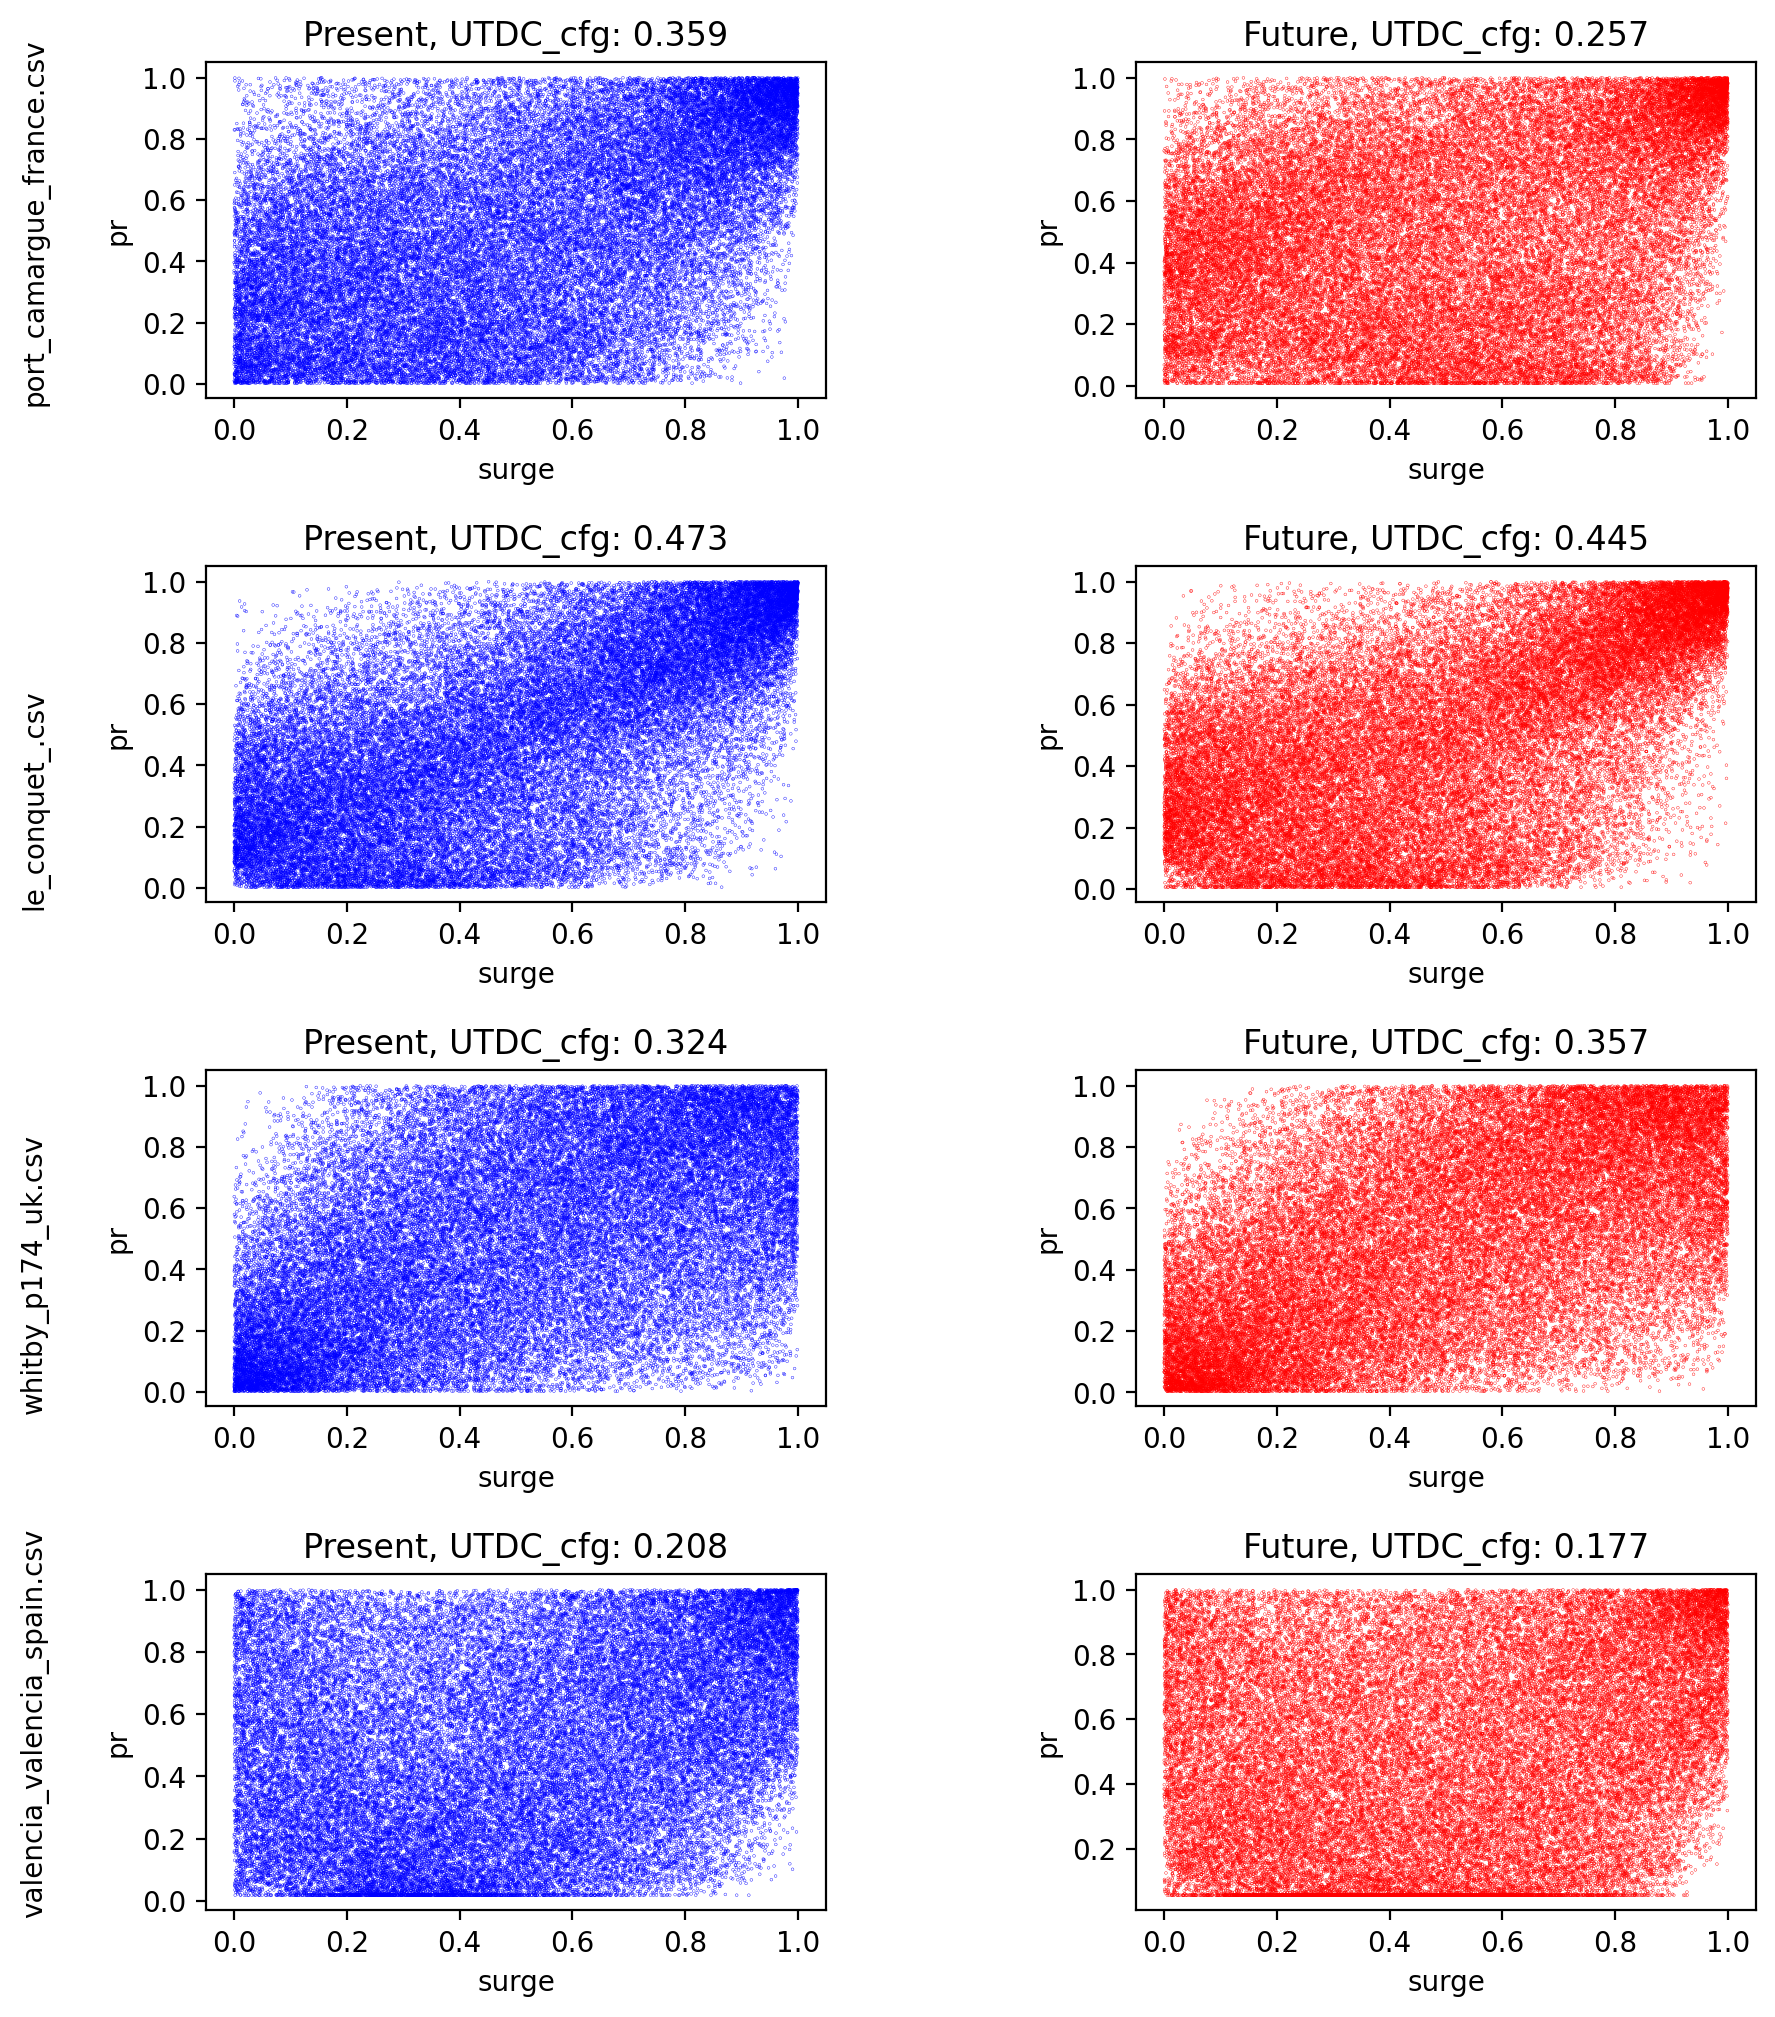

In [23]:
plt.figure(figsize=(10,12))
gs = fig.add_gridspec(4,2)
gs.update(wspace=.5,hspace=.5)
tgs = ['port_camargue_france.csv','le_conquet_.csv','whitby_p174_uk.csv','valencia_valencia_spain.csv']

for t,tg in enumerate(tgs):
    
    ax = plt.subplot(gs[t,0])
    data = surge_pr_windows.sel(window=2000,tg=tg)
    x,y = pseudo_obs(data.surge.values,data.pr.values)
    ax.scatter(x,y,edgecolor='blue',facecolor='None',s=.02)

    ax.set_title('Present, UTDC_cfg: '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2000).mean(dim='member_id').values)[0:5])
    ax.annotate(tg,(-.3,0),xycoords='axes fraction',rotation=90)
    ax.set_xlabel('surge')
    ax.set_ylabel('pr')
    
    ax = plt.subplot(gs[t,1])
    data = surge_pr_windows.sel(window=2080,tg=tg)
    x,y = pseudo_obs(data.surge.values,data.pr.values)
    ax.scatter(x,y,edgecolor='red',facecolor='None',s=.02)
    
    ax.set_title('Future, UTDC_cfg: '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2080).mean(dim='member_id').values)[0:5])
    
    #ax.set_title(tg+' (UTDC_cfg: '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2000).mean(dim='member_id').values)[0:5]+' -> '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2080).mean(dim='member_id').values)[0:5]+')')
    ax.set_xlabel('surge')
    ax.set_ylabel('pr')


In [27]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

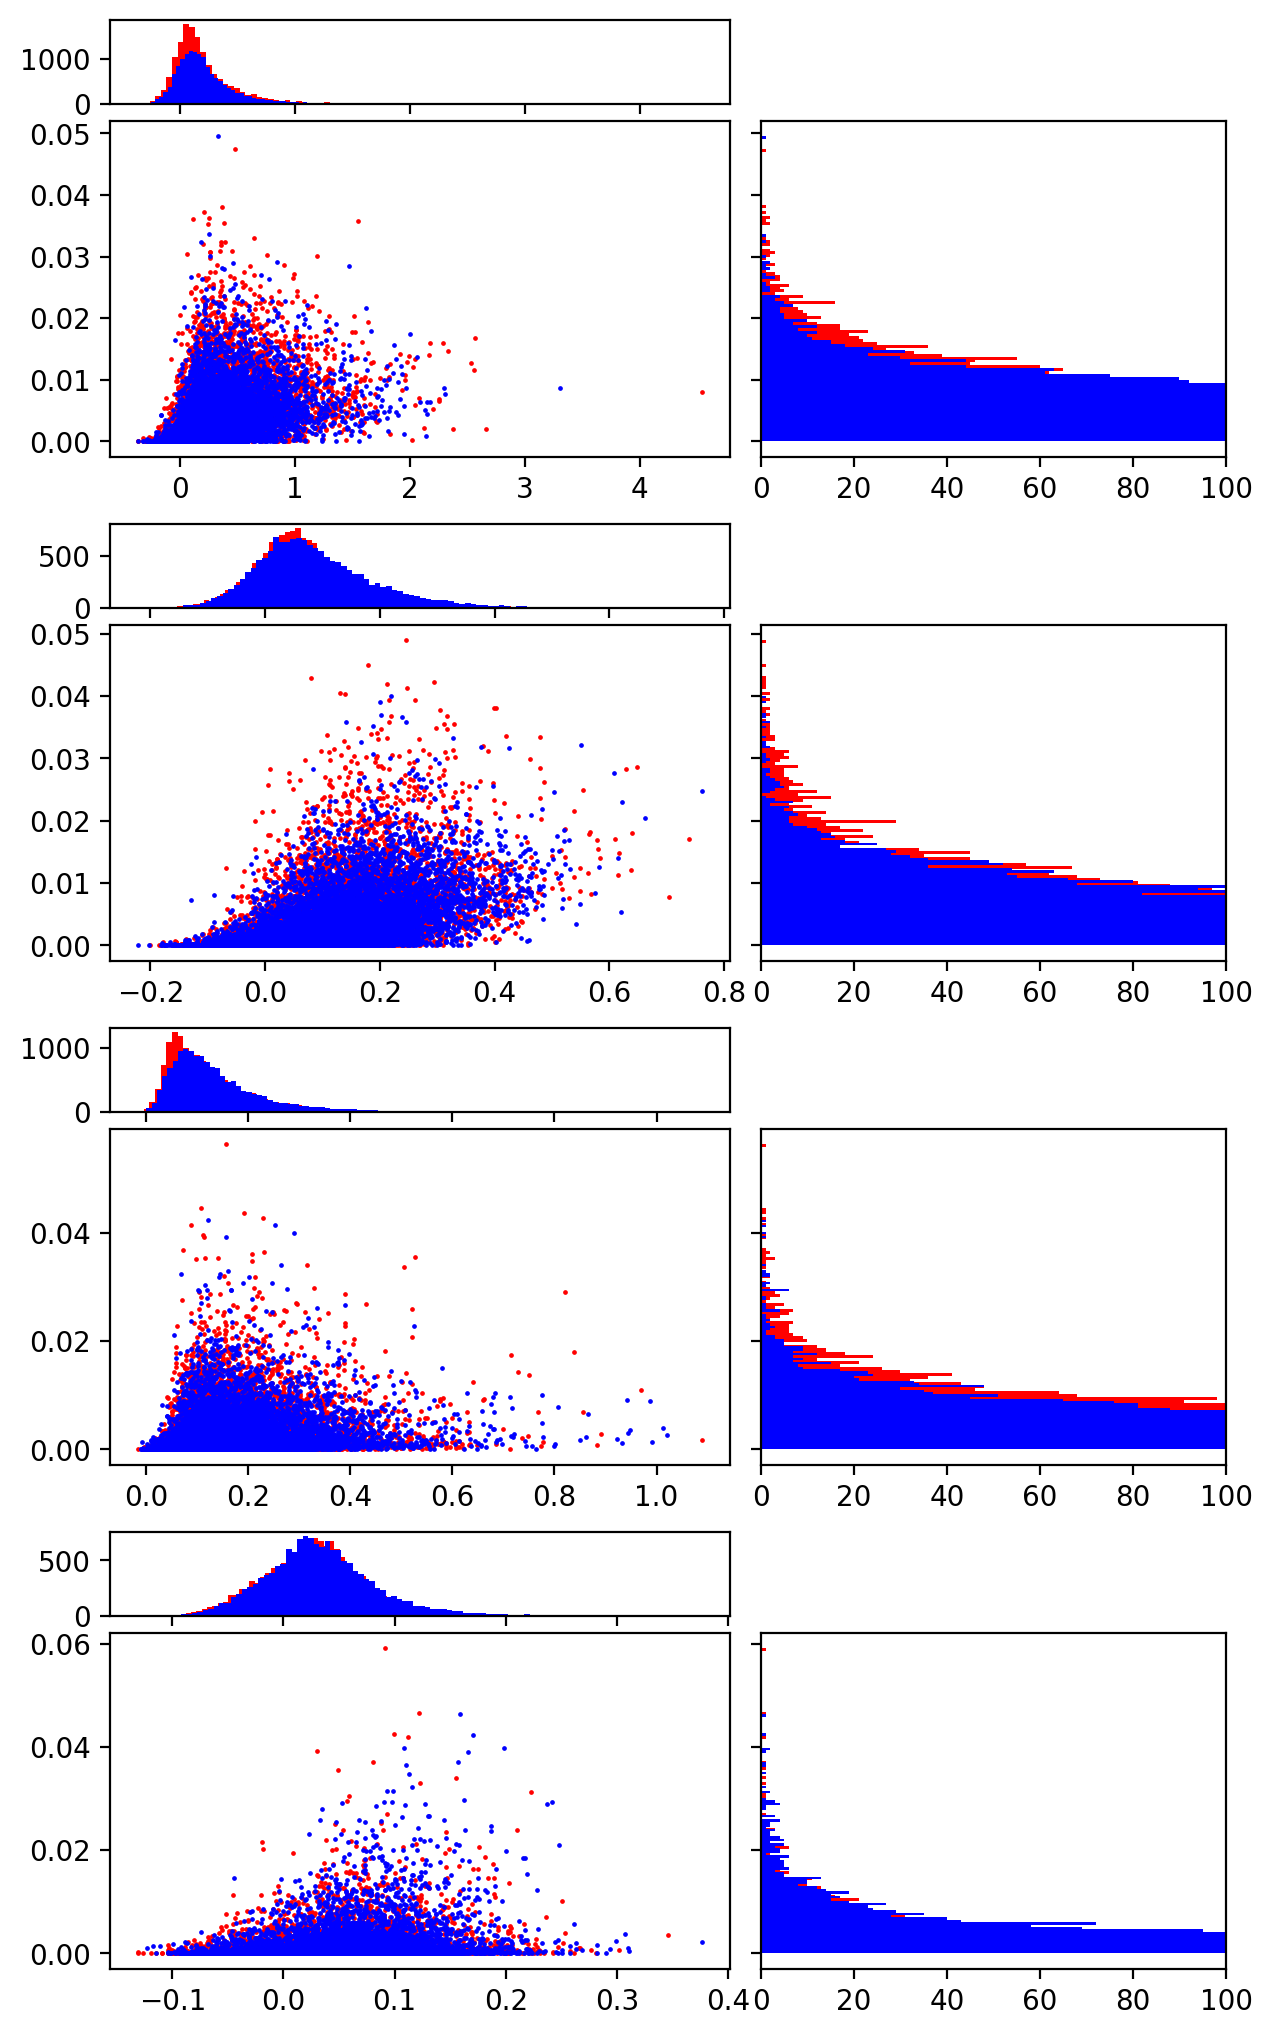

In [24]:
plt.figure(figsize=(10,12))
gs = fig.add_gridspec(4,2)
gs.update(wspace=.5,hspace=.5)
tgs = ['esbjerg_130121_denmark.csv','le_conquet_.csv','whitby_p174_uk.csv','valencia_valencia_spain.csv']

for t,tg in enumerate(tgs):
    ax = plt.subplot(gs[t,0])
    
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
    ax_histy = ax.inset_axes([1.05, 0, 0.75, 1], sharey=ax)
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax_histy.set_xlim([0,100])
    
    data = surge_pr_windows.sel(window=2080,tg=tg).isel(member_id=0)
    ax.scatter(data.surge,data.pr,color='red',s=.5)
    ax_histx.hist(data.surge, bins=100,color='red')
    ax_histy.hist(data.pr, bins=100, orientation='horizontal',color='red')
    
    data = surge_pr_windows.sel(window=2000,tg=tg).isel(member_id=0)
    ax.scatter(data.surge,data.pr,color='blue',s=.5)
    ax_histx.hist(data.surge, bins=100,color='blue')
    ax_histy.hist(data.pr, bins=100, orientation='horizontal',color='blue')
    
    
    #ax.set(aspect=1)
    
    '''
    
    #x,y = pseudo_obs(data.surge.values,data.pr.values)
    x = data.surge
    y=data.pr
    fig = plt.figure(constrained_layout=True)
    # Create the main axes, leaving 25% of the figure space at the top and on the
    # right to position marginals.
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # The main axes' aspect can be fixed.
    
    # Create marginal axes, which have 25% of the size of the main axes.  Note that
    # the inset axes are positioned *outside* (on the right and the top) of the
    # main axes, by specifying axes coordinates greater than 1.  Axes coordinates
    # less than 0 would likewise specify positions on the left and the bottom of
    # the main axes.
    
    # Draw the scatter plot and marginals.
    scatter_hist(x, y, ax, ax_histx, ax_histy)

    plt.show()
    
    '''


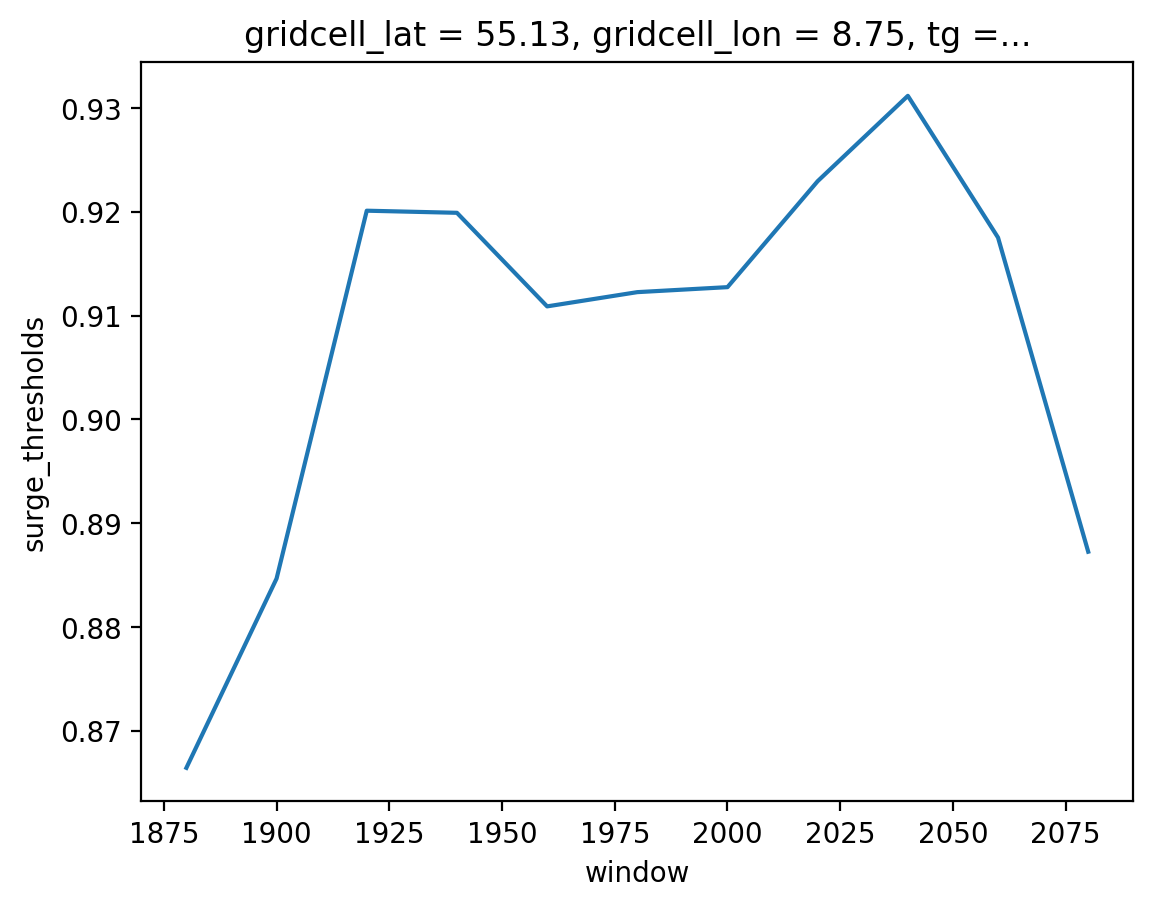

In [47]:
dependence.sel(tg='esbjerg_130121_denmark.csv').surge_thresholds.isel(quantile=-3).mean(dim='member_id').plot()

In [48]:
dependence.sel(tg='esbjerg_130121_denmark.csv').surge_thresholds.isel(quantile=-3).mean(dim='member_id').std(dim='window')

<xarray.DataArray 'surge_thresholds' ()>
array(0.0188066)
Coordinates:
    gridcell_lat  float64 ...
    gridcell_lon  float64 ...
    tg            <U26 'esbjerg_130121_denmark.csv'
    lat           float64 55.47
    lon           float64 8.433
    quantile      float64 0.97

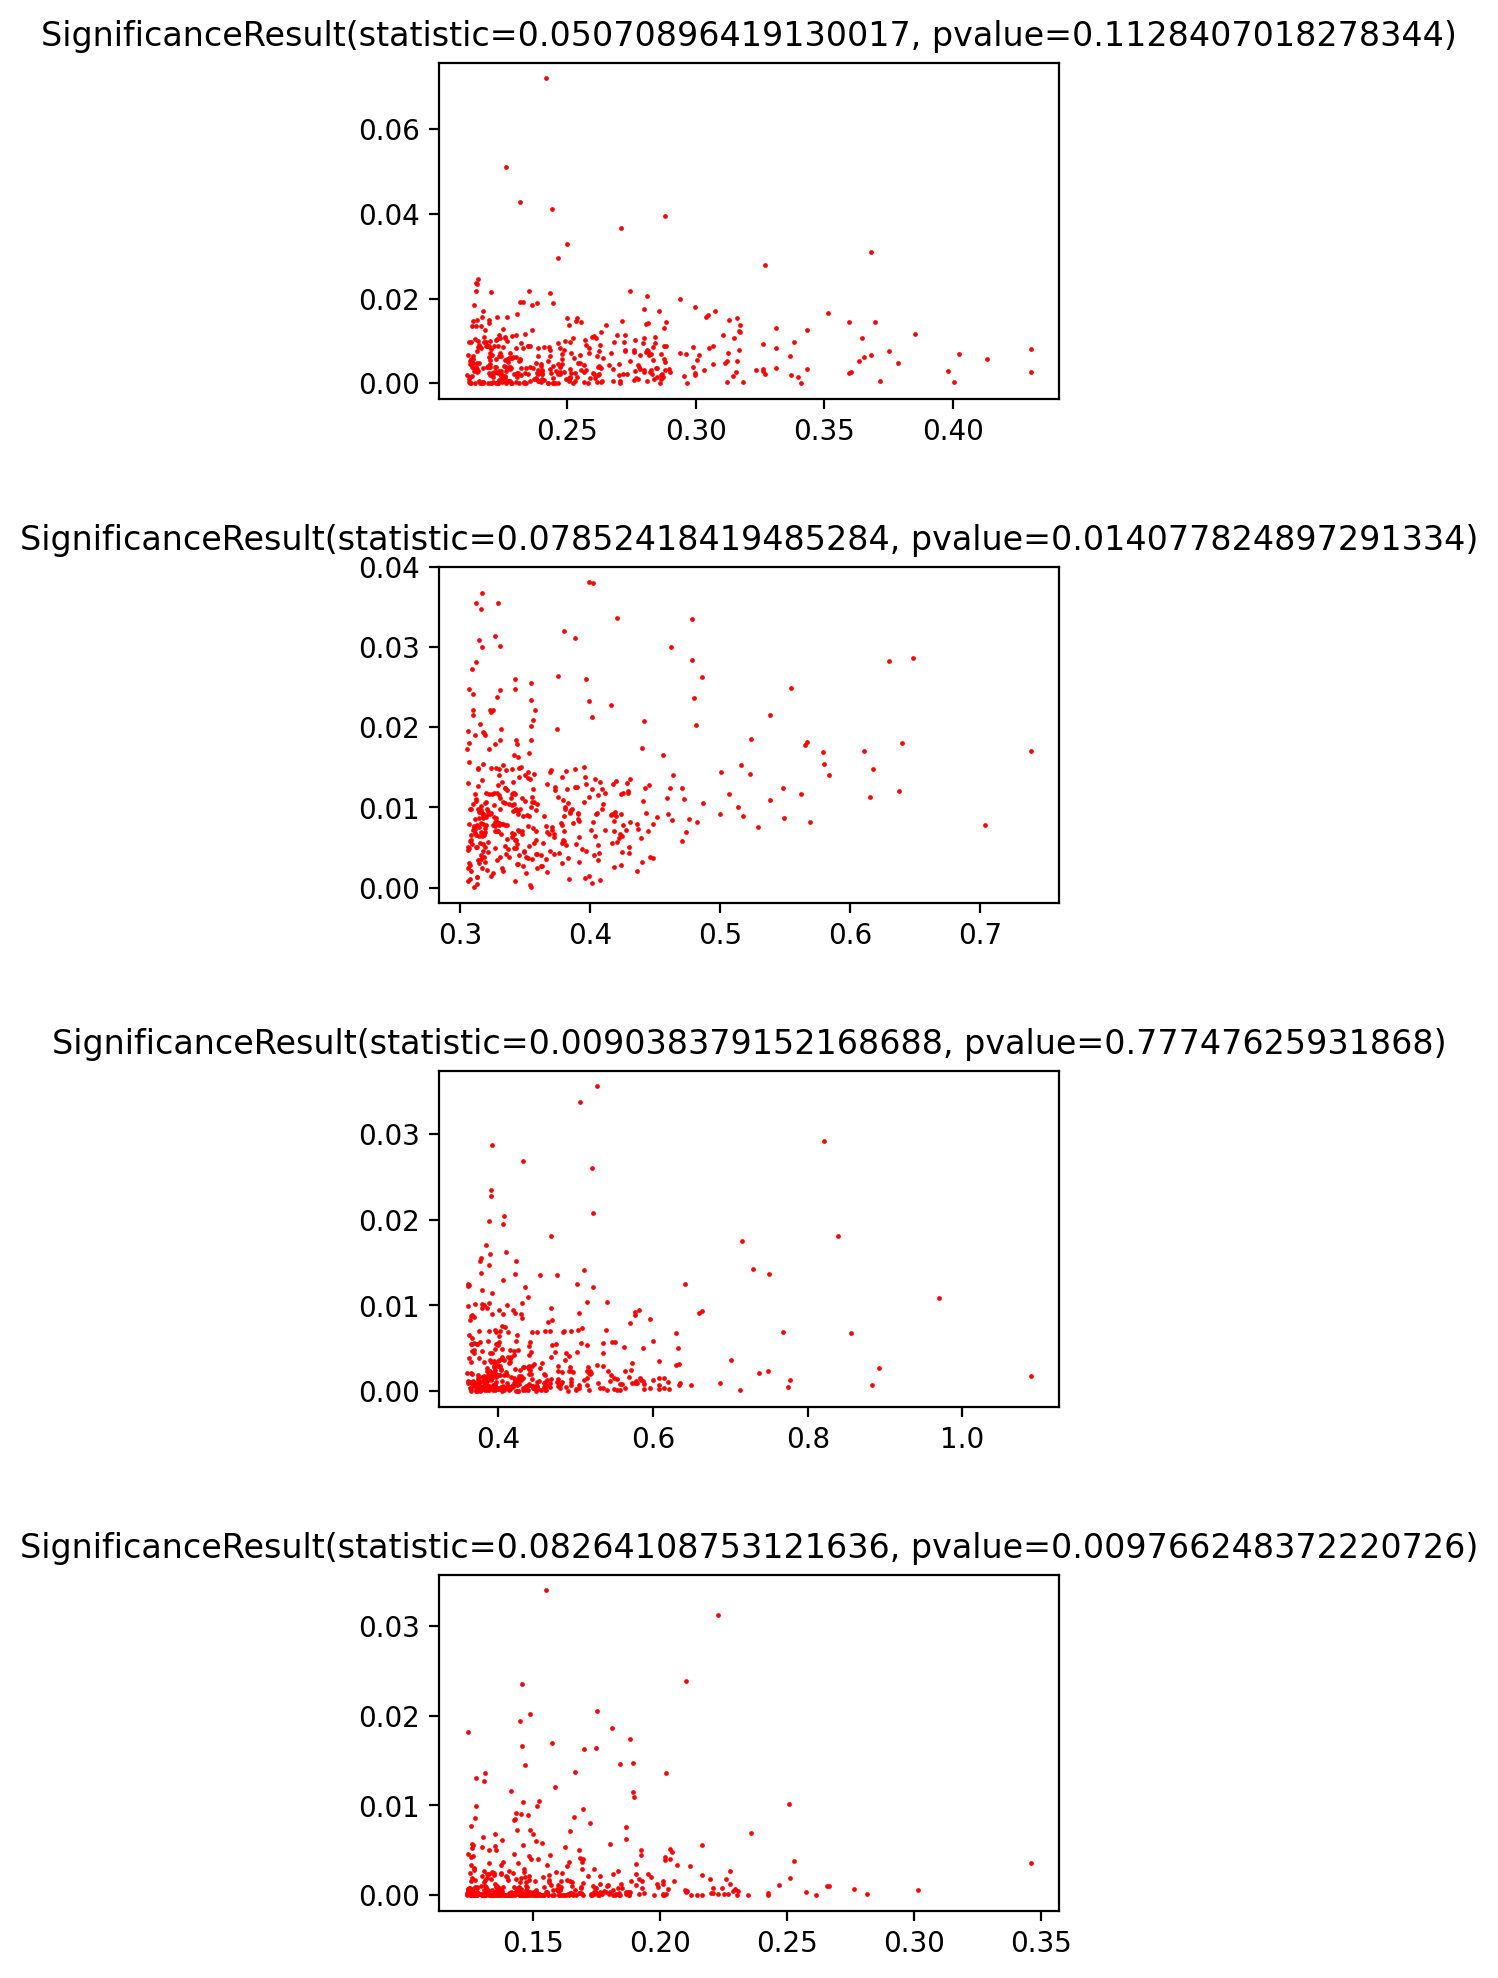

In [35]:
plt.figure(figsize=(10,12))
gs = fig.add_gridspec(4,2)
gs.update(wspace=.5,hspace=.5)
tgs = ['port_camargue_france.csv','le_conquet_.csv','whitby_p174_uk.csv','valencia_valencia_spain.csv']
from scipy.stats import kendalltau


for t,tg in enumerate(tgs):
    ax = plt.subplot(gs[t,0])
    data = surge_pr_windows.sel(window=2080,tg=tg).isel(member_id=0)
    ax.scatter(data.surge.where(data.surge>np.quantile(data.surge,.97)),data.pr.where(data.surge>np.quantile(data.surge,.97)),color='red',s=.5)
    ax.set_title(str(kendalltau(data.surge.where(data.surge>np.quantile(data.surge,.97),drop=True),data.pr.where(data.surge>np.quantile(data.surge,.97),drop=True))))

Breaking ties, does affect UTDC and Ktau for thresholds below 97%

In [10]:
import random

random.seed(10)
for tg in surge_pr_windows.tg.values:
    data=surge_pr_windows.sel(window=2000,tg=tg).isel(member_id=0).load()
    test = data.copy(deep=True)
    test.pr[np.where(test.pr==0)] = test.pr[np.where(data.pr==0)] + np.random.uniform(0,np.min(data.pr[data.pr>0]),len(np.where(data.pr==0)[0]))
    #print(tg)
    #print(np.min(data.pr.where(data.surge>np.quantile(data.surge,.97),drop=True)).values)
    #print(kendalltau(data.surge.where(data.surge>np.quantile(data.surge,.97),drop=True),data.pr.where(data.surge>np.quantile(data.surge,.97),drop=True)))
    #print(kendalltau(test.surge.where(test.surge>np.quantile(test.surge,.97),drop=True),test.pr.where(test.surge>np.quantile(test.surge,.97),drop=True)))


In [11]:
tg = 'le_conquet_.csv'
data=surge_pr_windows.sel(window=2000,tg=tg).isel(member_id=0).load()
utdc_pd = [utdc_at_threshold(data.surge.values,data.pr.values,thr)[0] for thr in np.arange(0.01,1,.01)]

data=surge_pr_windows.sel(window=2080,tg=tg).isel(member_id=0).load()
utdc_fut = [utdc_at_threshold(data.surge.values,data.pr.values,thr)[0] for thr in np.arange(0.01,1,.01)]


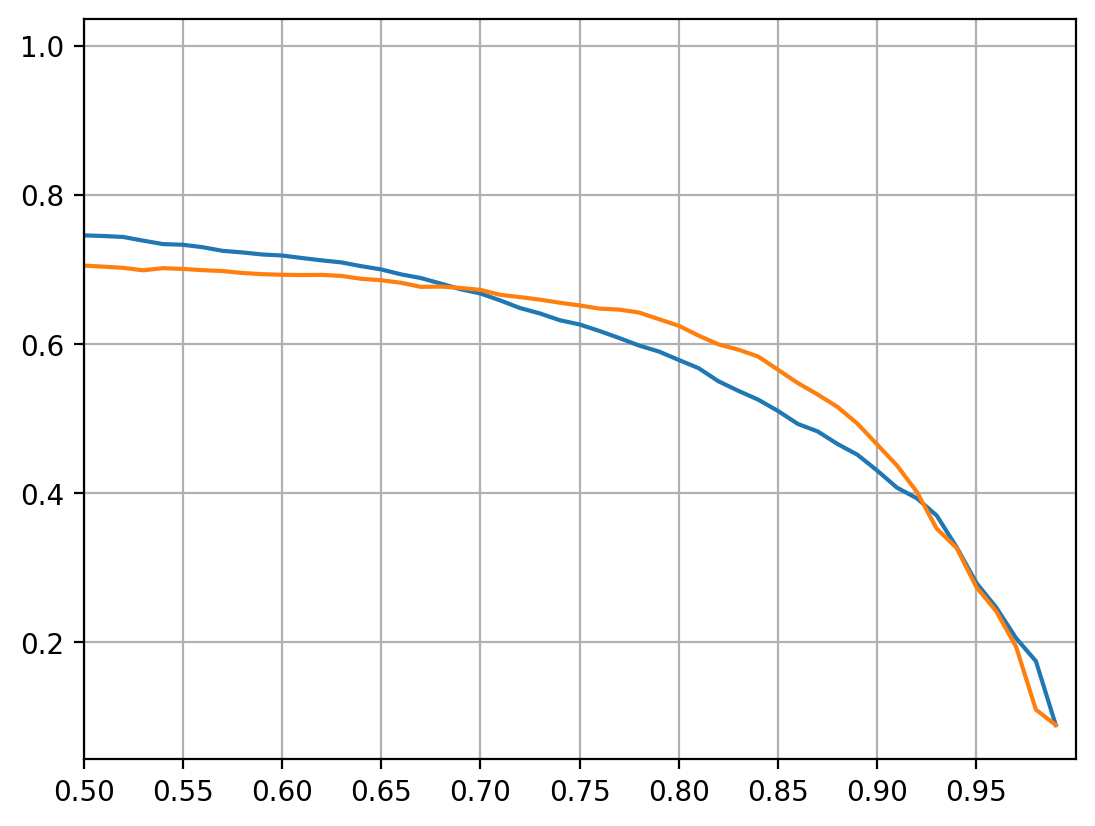

In [12]:
plt.figure()
plt.plot(np.arange(0.01,1,.01),utdc_pd,label='1981-2020')
plt.plot(np.arange(0.01,1,.01),utdc_fut,label='2061-2100')
plt.xticks(np.arange(0,1,.05))
plt.xlim([.5,1])
plt.grid()

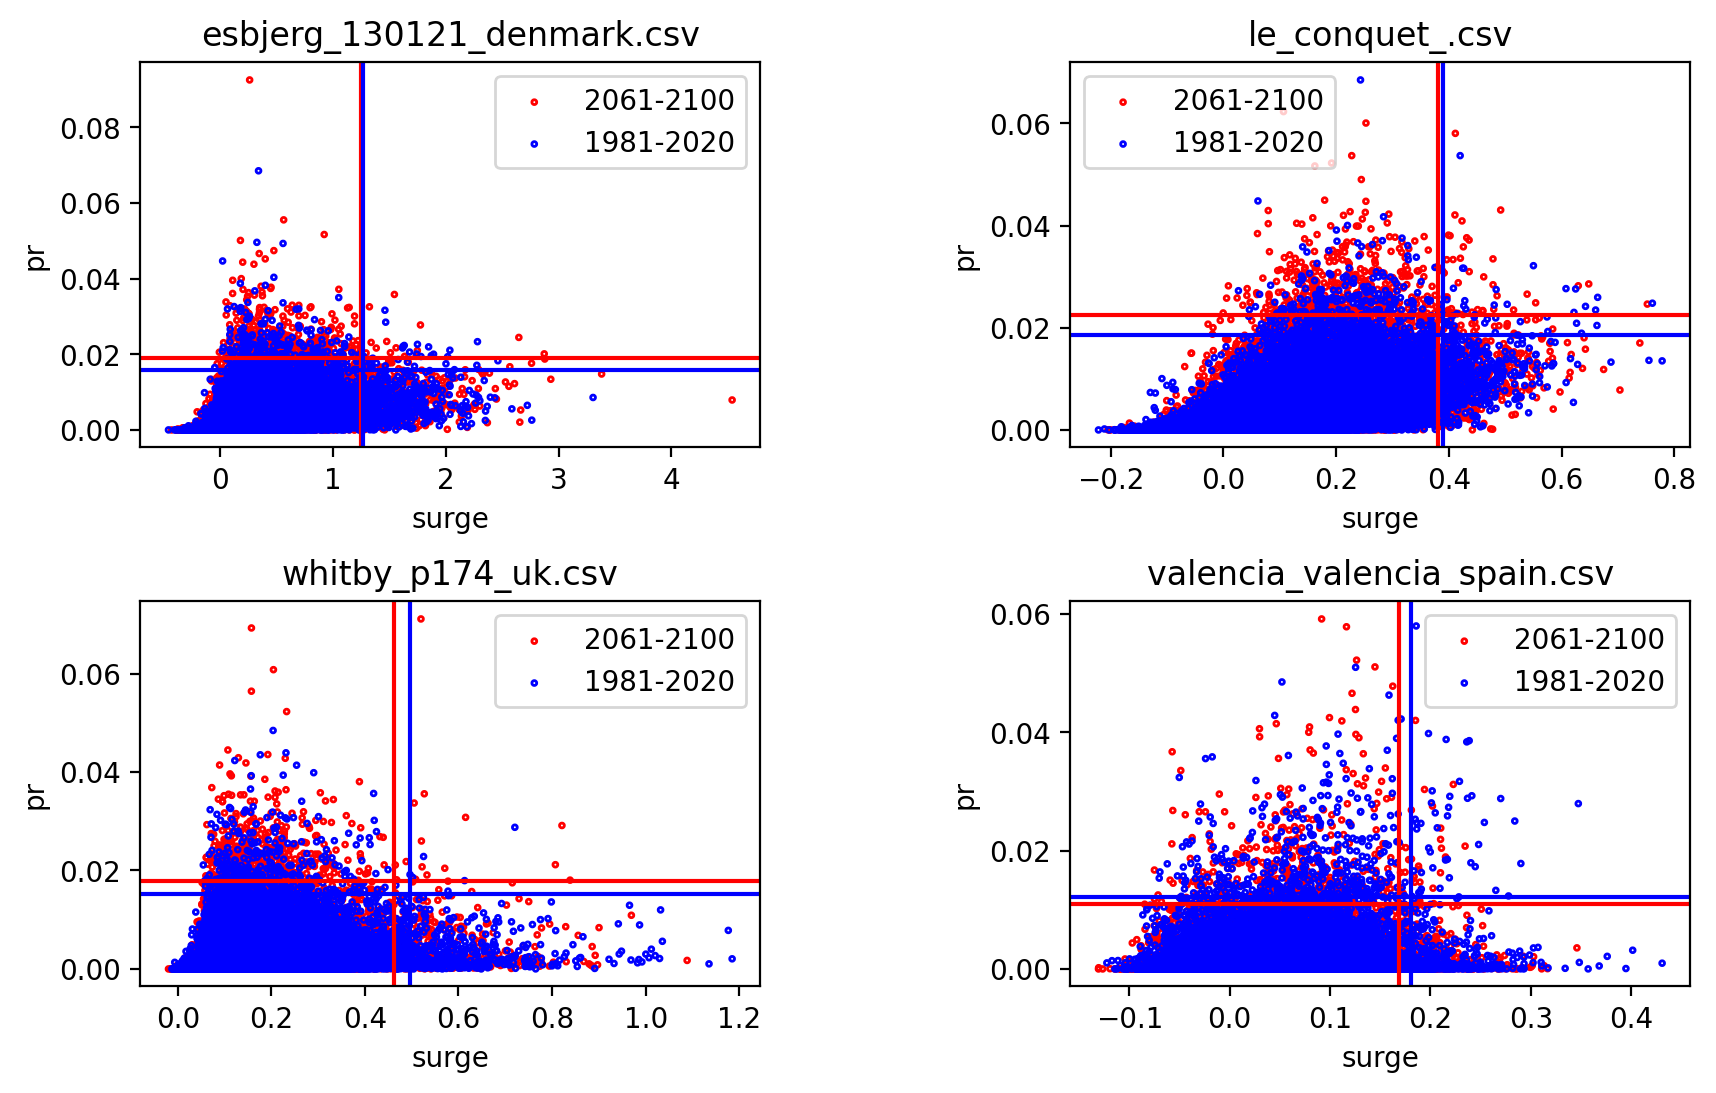

In [22]:
plt.figure(figsize=(10,6))
gs = fig.add_gridspec(2,2)
gs.update(wspace=.5,hspace=.4)
tgs = ['esbjerg_130121_denmark.csv','le_conquet_.csv','whitby_p174_uk.csv','valencia_valencia_spain.csv']

for t,tg in enumerate(tgs):
    
    ax = plt.subplot(gs[np.unravel_index(t,(2,2))])
    data = surge_pr_windows.sel(window=2080,tg=tg)
    ax.scatter(data.surge,data.pr,edgecolor='red',label='2061-2100',s=3,facecolor='None')
    ax.axvline(x=np.quantile(data.surge,.99),color='red')
    ax.axhline(y=np.quantile(data.pr,.99),color='red')
    data = surge_pr_windows.sel(window=2000,tg=tg)
    ax.scatter(data.surge,data.pr,label='1981-2020',s=3,edgecolor='blue',facecolor='None')
    ax.axvline(x=np.quantile(data.surge,.99),color='blue')
    ax.axhline(y=np.quantile(data.pr,.99),color='blue')
    #ax.set_title(tg+' (UTDC_cfg: '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2000).mean(dim='member_id').values)[0:5]+' -> '+str(dependence.utdc.sel(statistic='coef',estimator='cfg',tg=tg).sel(window=2080).mean(dim='member_id').values)[0:5]+')')
    ax.set_title(tg)
    ax.legend()
    ax.set_xlabel('surge')
    ax.set_ylabel('pr')


In [38]:
surge_pr_windows.tg.values

array(['arcachon_eyrac_.csv', 'montoir_de_bretagne_.csv',
       'barcelona_barcelona_spain.csv', 'paimboeuf_.csv',
       'saint_malo_.csv', 'portbury_p341_uk.csv', 'dover_p012_uk.csv',
       'portpatrick_p063_uk.csv', 'alcudia_alcudia_spain.csv',
       'formentera_formentera_spain.csv', 'donges_.csv',
       'aberdeen_p038_uk.csv', 'avonmouth_p060_uk.csv',
       'esbjerg_130121_denmark.csv', 'la_rochelle_la_palli_.csv',
       'monaco_port_hercule_france.csv', 'newhaven_p011_uk.csv',
       'le_havre_.csv', 'llandudno_p007_uk.csv', 'bangor_p662_uk.csv',
       'roscoff_.csv', 'port_vendres_france.csv', 'holyhead_p054_uk.csv',
       'portellen_p202_uk.csv', 'tregde_006_norway.csv',
       'le_conquet_.csv', 'saint_nazaire_.csv',
       'port_camargue_france.csv', 'morayfirth_p207_uk.csv',
       'marseille_france.csv', 'ullapool_p043_uk.csv', 'cordemais_.csv',
       'port_tudy_.csv', 'sagunto_sagunto_spain.csv',
       'bilbao_bilbao_spain.csv', 'northshields_p032_uk.csv',
      